### WGAIN Implementation and Evaluation


**WU Data Science Lab: Group IIASA 1:**

Viktor Gornik: h12122793\
Valentina Heinze: h12220160\
Tomislav Kolev: h12208645 \
Mira Radakovic: h62005377


**Description:**

Within this notebook we implemented the GAN-based imputation methods Slim GAIN (SGAIN), Wasserstein Slim GAIN with clipping Penalty (WSGAIN-CP) and Wasserstein Slim GAIN with Gradient Penalty (WSGAIN-GP) as outlined in [1]. The basic structure of the algorithms was given by codebase the for "SGAIN, WSGAIN-CP and WSGAIN-GP: Novel GAN Methods for Missing Data Imputation", provided by Neves et al. (2021).



*Reference:*

[1] Diogo Telmo Neves, Marcel Ganesh Naik, Alberto Proença,
      "SGAIN, WSGAIN-CP and WSGAIN-GP: Novel GAN Methods for Missing Data Imputation," International Conference on Computational Science (ICCS), 2021.

*Codebase:*

  * https://github.com/dtneves/ICCS_2021/tree/main

*Copyright for the Codebase:*

 Copyright (c) 2020 diogo telmo neves.
 All rights reserved.



In [1]:
import sys
sys.path.append("../")
from DataLab.purify.imputation import gain
from DataLab.purify.imputation.gain import SGAIN, WSGAIN_CP, WSGAIN_GP
from DataLab.GAIN.utils import rmse_loss
import os
import sys
from DataLab.GAIN.data_loader import data_loader
from DataLab.GAIN.data_dictionary import DATASETS
from argparse import ArgumentParser, Namespace
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from tqdm import tqdm
from time import time
from typing import Any, Callable, Dict, List, Set, Tuple, Union


Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
# check that the dictionary is correctly loaded in
DATASETS.keys()

dict_keys(['ARM2018_subset4', 'BRA2002_subset4', 'BRA2008_subset4', 'BRA2017_subset4', 'ETH2018_subset4', 'GHA2005_subset4', 'GHA2017_subset4', 'GTM2014_subset4', 'IND2004_subset4', '2002.BRA.urban', '2004.IND.urban', '2005.GHA.urban', '2008.BRA.urban', '2010.MNG.urban', '2010.VNM.urban', '2011.IND.urban', '2014.GTM.urban', '2014.KHM.urban', '2017.BRA.urban', '2017.GHA.urban', '2018.ARM.urban', '2018.ETH.urban', '2018.NGA.urban', '2019.KHM.urban', '2019.NPL.urban', '2019.UGA.urban', '2020.MEX.urban', '2020.RUS.urban', '2020.VNM.urban', '2021.MNG.urban', '2002.BRA.rural', '2004.IND.rural', '2005.GHA.rural', '2008.BRA.rural', '2010.MNG.rural', '2011.IND.rural', '2010.VNM.rural', '2014.GTM.rural', '2014.KHM.rural', '2017.BRA.rural', '2017.GHA.rural', '2018.ARM.rural', '2018.ETH.rural', '2018.NGA.rural', '2019.KHM.rural', '2019.NPL.rural', '2019.UGA.rural', '2020.MEX.rural', '2020.RUS.rural', '2020.VNM.rural', '2021.MNG.rural', 'ARM2018_subset1', 'BRA2002_subset1', 'BRA2008_subset1', 'BRA2

In [16]:
# generate subsets for the first rounds of imputation
country_combinations = all_data[['country', 'year']].drop_duplicates()
country_combinations= country_combinations.values.tolist()



for combination in country_combinations:

    # generate subset 1

    subset1_country = all_data[all_data["country"] == combination[0]]
    subset1_country = subset1_country[subset1_country["year"] == combination[1]]
    subset1_country = subset1_country[['year', 'country', 'hhid', 'hhweight', 'climatezone', 'urban',  'head_age', 'nrooms', 'head_literate','hhsize', 'tv', 'music', 'fridge', 'exp',
       'exp_cap_group']]
    subset1_country.to_csv(str("datasets/"+combination[0]+str(combination[1])+"_subset1.csv"), index=False)
    #subset1_country.dropna(subset=["exp"]).to_csv(str("datasets/"+combination[0]+str(combination[1])+"_subset1_noNA.csv"), index=False)


    # generate subset4

    all_country = all_data[all_data["country"] == combination[0]]
    all_country = all_country[all_country["year"] == combination[1]]
    all_country = all_country[["year","country","hhid","hhweight", "climatezone", "urban",
 "head_age", "nrooms", "head_literate", "hhsize", "tv", "music", "fridge", "exp", "exp_cap_group", "head_male", "frwd_exp", "frwd_cons", "petrol_exp", "scooter", "car", "publictransport_exp", "publictransport", "washmach", "elec_any", "totbiom_cons", "elec_cons", "gas_cons"]]
    all_country.to_csv(str("datasets/"+combination[0]+str(combination[1])+"_subset4.csv"), index=False)
    #all_country.dropna(subset=["totbiom_cons", "elec_cons", "gas_cons"]).to_csv(str("datasets/"+combination[0]+str(combination[1])+"_subset4_noNA.csv"), index=False)

'for combination in country_combinations:\n\n    # generate subset4\n\n    all_country = all_data[all_data["country"] == combination[0]]\n    all_country = all_country[all_country["year"] == combination[1]]\n    all_country = all_country[["year","country","hhid","hhweight", "climatezone", "urban",\n "head_age", "nrooms", "head_literate", "hhsize", "tv", "music", "fridge", "exp", "exp_cap_group", "head_male", "frwd_exp", "frwd_cons", "petrol_exp", "scooter", "car", "publictransport_exp", "publictransport", "washmach", "elec_any", "totbiom_cons", "elec_cons", "gas_cons"]]\n    all_country.to_csv(str("datasets/"+combination[0]+str(combination[1])+"_subset4.csv"), index=False)\n    all_country.dropna(subset=["totbiom_cons", "elec_cons", "gas_cons"]).to_csv(str("datasets/"+combination[0]+str(combination[1])+"_subset4_noNA.csv"), index=False)\n\n    # generate subset 1\n\n    subset1_country = all_data[all_data["country"] == combination[0]]\n    subset1_country = subset1_country[subset1_coun

In [4]:
# generate split datasets from outlier-removed datasets for imputation
for year, country in [[2002, 'BRA'],
        [2004, 'IND'],
        [2005, 'GHA'],
        [2008, 'BRA'],
        [2010, 'MNG'],
        [2011, 'IND'],
        [2010, 'VNM'],
        [2014, 'GTM'],
        [2014, 'KHM'],
        [2014, 'ZAF'],
        [2017, 'BRA'],
        [2017, 'GHA'],
        [2018, 'ARM'],
        [2018, 'ETH'],
        [2018, 'NGA'],
        [2019, 'KHM'],
        [2019, 'NPL'],
        [2019, 'UGA'],
        [2020, 'MEX'],
        [2020, 'RUS'],
        [2020, 'VNM'],
        [2021, 'MNG']]:

    data =pd.read_csv(f"cleaned_df/{year}.{country}.csv")

    # put expenditure and consumption variables into per capita terms
    data["exp"] = data["exp"]/data["hhsize"]
    data["totbiom_cons"] = data["totbiom_cons"]/data["hhsize"]
    data["elec_cons"] = data["elec_cons"]/data["hhsize"]
    data["gas_cons"] = data["gas_cons"]/data["hhsize"]
    data["totbiom_cons"] = data["totbiom_cons"]/data["hhsize"]
    data["frwd_cons"] = data["frwd_cons"]/data["hhsize"]
    data["frwd_exp"] = data["frwd_exp"]/data["hhsize"]
    data["publictransport_exp"] = data["publictransport_exp"]/data["hhsize"]

    # apply the urban/rural split
    urban = data[data["urban"]==1]
    rural = data[data["urban"]==0]

    #urban.to_csv(f"cleaned_df/{year}.{country}.urban.csv", index=False)
    #rural.to_csv(f"cleaned_df/{year}.{country}.rural.csv", index = False)

In [2]:

def accuracy_and_auroc(
        algo: str, model: BaseEstimator, original_data: np.ndarray, imputed_data: np.ndarray, target: np.ndarray,
        verbose: bool = False) -> Tuple[float, float]:
    score_accuracy: float = 0
    score_auroc: float = 0
    scaler: MinMaxScaler = MinMaxScaler(feature_range=((0.00, 1.00) if algo == 'GAIN' else (-1.00, +1.00)))
    original: np.ndarray = scaler.fit_transform(X=original_data.copy())
    imputed: np.ndarray = scaler.transform(X=imputed_data)
    target = target.to_numpy()
    model.fit(X=original, y=target)
    score_accuracy = cross_val_score(model,X=imputed, y=target, cv=KFold(n_splits=2) )

    # score_accuracy = accuracy_score(y_true=target, y_pred=model.predict(X=imputed))
    score_auroc =0 # TBD
    '''if len(np.unique(target)) > 2:  # multiclass case
        score_auroc = roc_auc_score(
            y_true=target, y_score=model.predict_proba(X=imputed), multi_class='ovr')
    else:  # binary case
        score_auroc = roc_auc_score(
            y_true=target, y_score=model.predict_proba(X=imputed)[:, 1], multi_class='ovr')
    if verbose:
        print("accuracy_and_auroc():")
        print(f"\taccuracy score: {score_accuracy:.4f}")
        print(f"\tauroc score:    {score_auroc:.4f}")
    '''
    return score_accuracy, score_auroc

In [3]:
def report(args: Namespace,
           model: BaseEstimator,
           results: Dict[str, Dict[str, Dict[str, List[Union[np.ndarray, float]]]]]) -> None:
    print(f"miss rate:    {args.miss_rate}")
    print(f"batch size:   {args.batch_size}")
    print(f"alpha:        {args.alpha}")
    print(f"clip values:  ({-1 * args.clip_value}, {+1 * args.clip_value})")
    print(f"optimizer:    {args.optimizer}")
    print(f"learn. rate:  {args.learn_rate}")
    if args.optimizer == 'GDA':
        pass
    elif args.optimizer == 'RMSProp':
        print(f"decay:        {args.decay}")
        print(f"momentum:     {args.momentum}")
        print(f"epsilon:      {args.epsilon}")
    else:  # if args.optimizer == 'Adam':
        print(f"beta 1:       {args.beta_1}")
        print(f"beta 2:       {args.beta_2}")
        print(f"epsilon:      {args.epsilon}")
    print(f"# iterations: {args.n_iterations}")
    print(f"# critic:     {args.n_critic}")
    print(f"# runs:       {args.n_runs}")
    print(f"verbose:      {args.verbose}")
    print(f"model:        {model.__str__()}")
    for dataset, dataset_results in results.items():
        print(f"dataset: {dataset}")
        # print(f"\tshape:        {data_shape}")
        for algo, algo_results in dataset_results.items():
            print(f"\talgorithm: {algo}")
            print(f"\t\trmse:             {np.mean(algo_results['rmse_lst']):.4f} "
                  f"({np.std(algo_results['rmse_lst']):.4f})")
            print(f"\t\trmse list:        {algo_results['rmse_lst']}")
            print(f"\t\texec. time (s):   {np.mean(algo_results['exec_lst']):.4f} "
                  f"({np.std(algo_results['exec_lst']):.4f})")
            print(f"\t\texec. times list: {algo_results['exec_lst']}")
            print(f"\t\taccuracy:         {np.mean(algo_results['accuracy_lst']):.4f} "
                  f"({np.std(algo_results['accuracy_lst']):.4f})")
            print(f"\t\taccuracy list:    {algo_results['accuracy_lst']}")
            print(f"\t\tauroc:            {np.mean(algo_results['auroc_lst']):.4f} "
                  f"({np.std(algo_results['auroc_lst']):.4f})")
            print(f"\t\tauroc list:       {algo_results['auroc_lst']}")


In [4]:
# implementation of the main algorithm:

def main(args: Namespace,unknown) -> None:
    algos: List[str] = [algo.strip() for algo in args.algos.split(',')]
    algos_set: Set[str] = set(['GAIN', 'SGAIN', 'WSGAIN-CP', 'WSGAIN-GP'])
    datasets: List[str] = [dataset.strip() for dataset in args.datasets.split(',')]
    datasets_set: Set[str] = set(['2002.BRA.urban','2004.IND.urban','2005.GHA.urban','2008.BRA.urban','2010.MNG.urban','2010.VNM.urban','2011.IND.urban','2014.GTM.urban','2014.KHM.urban','2017.BRA.urban','2017.GHA.urban','2018.ARM.urban','2018.ETH.urban','2018.NGA.urban','2019.KHM.urban','2019.NPL.urban','2019.UGA.urban','2020.MEX.urban','2020.RUS.urban','2020.VNM.urban','2021.MNG.urban','2002.BRA.rural','2004.IND.rural','2005.GHA.rural','2008.BRA.rural','2010.MNG.rural','2010.VNM.rural','2014.GTM.rural','2014.KHM.rural','2017.BRA.rural','2017.GHA.rural','2018.ARM.rural','2018.ETH.rural','2018.NGA.rural','2019.KHM.rural','2019.NPL.rural','2019.UGA.rural','2020.MEX.rural','2020.RUS.rural','2020.VNM.rural','2021.MNG.rural',"2011.IND.rural", "2014.ZAF.urban","2014.ZAF.rural"])
    callables: Dict[str, Callable[[Namespace, Tuple[int, int], Dict[str, Any]], np.ndarray]] = {
        'GAIN': gain, 'SGAIN': SGAIN, 'WSGAIN-CP': WSGAIN_CP, 'WSGAIN-GP': WSGAIN_GP}
    results: Dict[str, Dict[str, Dict[str, List[Union[np.ndarray, float]]]]]

    if algos == ['ALL']:
        algos = sorted(algos_set)
    else:
        if not set(algos).issubset(algos_set):
            raise ValueError(f"The following algorithms are NOT supported: {set(algos) - algos_set}")
    if datasets == ['ALL']:
        datasets = sorted(datasets_set)
    else:
        if not set(datasets).issubset(datasets_set):
            raise ValueError(f"The following datasets are NOT supported: {set(datasets) - datasets_set}")

    results = {dataset: {algo: {'rmse_lst': [], 'exec_lst': [], 'accuracy_lst': [], 'auroc_lst': []} for algo in algos}
               for dataset in datasets}

    for run in range(args.n_runs):
        tqdm.write(f"run: {run}")  # "helps" in long runs

        data: np.ndarray
        miss: np.ndarray
        mask: np.ndarray
        imputed_data: np.ndarray
        model: BaseEstimator
        score_accuracy: float
        score_auroc: float
        t0: float
        t1: float
        df: pd.DataFrame

        for dataset in datasets:
            tqdm.write(f"dataset: {dataset}")  # "helps" in long runs

            data, miss, mask = data_loader(data_name=dataset, miss_rate=args.miss_rate)
            # data, miss, mask, trgt = matrices_and_target(dataset=args.dataset, miss_rate=args.miss_rate)

            df = pd.read_csv(f"./cleaned_df/{dataset}.csv")

            # ['year', 'country', 'hhid', 'hhweight', 'urban', 'hhsize', 'head_age',
    #        'head_male', 'head_literate', 'nrooms', 'tv', 'music', 'fridge', 'exp',
    #        'totbiom_cons', 'elec_cons', 'gas_cons', 'frwd_exp', 'frwd_cons',
    #        'petrol_exp', 'scooter', 'car', 'publictransport_exp',
    #        'publictransport', 'washmach', 'elec_any']

            cols = df.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] # still hardcoded in

            df[DATASETS[dataset]["target"]] = LabelEncoder().fit_transform(df[DATASETS[dataset]["target"]])


            for algo in algos:
                t0 = time()
                if algo in ['SGAIN', 'WSGAIN-CP', 'WSGAIN-GP']:
                    imputed_data = callables[algo](
                        data=miss,
                        algo_parameters={key.strip(): value for key, value in args.__dict__.items()}).execute()
                else:  # if algo in ['GAIN']:
                    imputed_data = callables[algo](
                        data_x=miss, gain_parameters={key.strip(): value for key, value in args.__dict__.items()})
                t1 = time()

                results[dataset][algo]['rmse_lst'].append(
                #    rmse_loss(ori_data=data, imputed_data=imputed_data, data_m=mask))
                np.sqrt(np.mean(((data - imputed_data) * (1 - mask)) ** 2)))
                residuals_df = pd.DataFrame(((data - imputed_data) * (1 - mask)))

                results[dataset][algo]['exec_lst'].append(t1 - t0)
                model = DATASETS[dataset]["model"]["class"](**DATASETS[dataset]["model"]["kwargs"])
                score_accuracy, score_auroc = accuracy_and_auroc(
                    algo=algo,
                    model=model,
                    original_data=data, imputed_data=imputed_data, target=df[DATASETS[dataset]["target"]],
                    verbose=False)
                results[dataset][algo]['accuracy_lst'].append(score_accuracy)
                results[dataset][algo]['auroc_lst'].append(score_auroc)
                df_run =pd.DataFrame(imputed_data)
                df_run.columns = cols
                df_run.to_csv("cleaned_df/"+str(dataset)+"_imputation_run" + str(run) + "_" + str(algo) + "2.csv", index=False)
                data_pr=pd.DataFrame(data)
                data_pr.columns=cols
                #data_pr.to_csv("datasets/imputations/"+str(dataset)+"original_run" + str(run) + #"_" + str(algo) + ".csv", index=False)
                residuals_df.columns = cols
                #residuals_df.to_csv("datasets/imputations/"+str(dataset)+"residuals_run" + #str(run) + "_" + str(algo) + ".csv", index=False)
                #print(((data_pr - df_run) * (1 - mask)) ** 2)


    df = pd.DataFrame(imputed_data)
    df.columns=cols

    #df.to_csv("cleaned_df/"+str(dataset)+"_imputation.csv", index=False)
    report(args=args, model=model, results=results)

In [5]:
if __name__ == "__main__":
    parser: ArgumentParser = ArgumentParser()

    parser.add_argument(
        '--algos',
        help="a csv list of the algorithms to run (e.g., 'GAIN,SGAIN,WSGAIN-CP,WSGAIN-GP')",
        #choices=['GAIN', 'SGAIN', 'WSGAIN-CP', 'WSGAIN-GP'],
        default= "WSGAIN-CP,WSGAIN-GP,SGAIN",
        type=str)
    parser.add_argument(
        '--datasets',
        help="a csv list of datasets short names",
        # choices=['breast', 'cover-type', 'credit', 'eeg', 'iris', 'letter',
        #          'mushroom', 'news', 'spam', 'wine-red', 'wine-white', 'yeast'],
        default="2011.IND.urban,2011.IND.rural",
        type=str)
    parser.add_argument(
        '--miss_rate',
        help="missing data probability",
        default=0,
        type=float)
    parser.add_argument(
        '--batch_size',
        help="number of samples in mini-batch",
        default=256, #128, #256,
        type=int)
    parser.add_argument(
        '--hint_rate',  # NOTE: the algorithms SGAIN, WSGAIN-CP, and WSGAIN-GP do NOT use this parameter,
        help='hint probability',  # it is here just because the GAIN algorithm requires the `hint_rate` parameter
        default=0.9,
        type=float)
    parser.add_argument(
        '--alpha',
        help="hyper-parameter to compute generator's loss",
        default=100,
        type=float)
    parser.add_argument(
        '--lambd',
        help="hyper-parameter to compute critic's loss",
        default=10,
        type=float)
    parser.add_argument(
        '--clip_value',
        help="clip (penalty) value",
        default=0.01,
        type=float)
    parser.add_argument(
        '--optimizer',
        help="solvers' optimizer",
        choices=['Adam', 'GDA', 'RMSProp'],
        default='Adam',
        type=str)
    parser.add_argument(
        '--learn_rate',
        help="optimizer's learning rate",
        default=1e-3,
        type=float)
    parser.add_argument(
        '--beta_1',
        help="Adam optimizer's hyper-parameter (1st moment estimates)",
        default=0.900,
        type=float)
    parser.add_argument(
        '--beta_2',
        help="Adam optimizer's hyper-parameter (2nd moment estimates)",
        default=0.999,
        type=float)
    parser.add_argument(
        '--decay',
        help="RMSProp optimizer's hyper-parameter (discounting factor for the history/coming gradient)",
        default=0.900,
        type=float)
    parser.add_argument(
        '--momentum',
        help="RMSProp optimizer's hyper-parameter (a scalar tensor)",
        default=0.000,
        type=float)
    parser.add_argument(
        '--epsilon',
        help="Adam hyper-parameter to ensure numerical stability or RMSProp hyper-parameter to avoid zero denominator",
        default=1e-08,
        type=float)
    parser.add_argument(
        '--n_iterations',
        help="number of training iterations",
        default=10000, #10000,
        type=int)
    parser.add_argument(
        '--n_critic',
        help="number of additional iterations to train the critic",
        default=5,
        type=int)
    parser.add_argument(
        '--n_runs',
        help="number of runs",
        default=3,
        type=int)
    parser.add_argument(
        '--verbose',
        help="to control verbosity",
        choices=['False', 'True'],  # `bool` type does NOT work as expected
        default='False',  # `bool` type does NOT work as expected
        type=str)  # `bool` type does NOT work as expected
    args, unknown = parser.parse_known_args()
    main(args, unknown = parser.parse_known_args())  # rock 'n roll

# python main.py --algos="GAIN,SGAIN,WSGAIN-CP,WSGAIN-GP" --datasets="ARM2018_subset4_eval" --miss_rate=0.2 --optimizer=GDA --learn_rate=0.001 --n_iterations=1000 --n_runs=3

run: 0
dataset: 2011.IND.urban


C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


100%|██████████| 3334/3334 [01:22<00:00, 40.44it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
100%|██████████| 3334/3334 [01:23<00:00, 40.10it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: Runtim

dataset: 2011.IND.rural


C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
100%|██████████| 3334/3334 [01:37<00:00, 34.32it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asar

run: 1
dataset: 2011.IND.urban


C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
100%|██████████| 3334/3334 [01:29<00:00, 37.21it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asar

dataset: 2011.IND.rural


C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
100%|██████████| 3334/3334 [01:40<00:00, 33.06it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asar

run: 2
dataset: 2011.IND.urban


C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
100%|██████████| 3334/3334 [01:26<00:00, 38.50it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asar

dataset: 2011.IND.rural


C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
100%|██████████| 3334/3334 [01:36<00:00, 34.65it/s]
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asar

miss rate:    0
batch size:   256
alpha:        100
clip values:  (-0.01, 0.01)
optimizer:    Adam
learn. rate:  0.001
beta 1:       0.9
beta 2:       0.999
epsilon:      1e-08
# iterations: 10000
# critic:     5
# runs:       3
verbose:      False
model:        HistGradientBoostingRegressor(max_depth=5, max_iter=3000)
dataset: 2011.IND.urban
	algorithm: WSGAIN-CP
		rmse:             nan (nan)
		rmse list:        [np.float64(nan), np.float64(nan), np.float64(nan)]
		exec. time (s):   89.1837 (2.2739)
		exec. times list: [86.0004072189331, 91.17069244384766, 90.37992930412292]
		accuracy:         0.9903 (0.0023)
		accuracy list:    [array([0.99324188, 0.99065405]), array([0.99244532, 0.98890017]), array([0.99047787, 0.98626208])]
		auroc:            0.0000 (0.0000)
		auroc list:       [0, 0, 0]
	algorithm: WSGAIN-GP
		rmse:             nan (nan)
		rmse list:        [np.float64(nan), np.float64(nan), np.float64(nan)]
		exec. time (s):   84.5027 (2.8413)
		exec. times list: [84.2975575923

In [18]:
# put urban and regional dataframes back together
for year, country in [[2002, 'BRA'],
        [2004, 'IND'],
        [2005, 'GHA'],
        [2008, 'BRA'],
        [2010, 'MNG'],
        [2011, 'IND'],
        [2010, 'VNM'],
        [2014, 'GTM'],
        [2014, 'KHM'],
        [2017, 'BRA'],
        [2017, 'GHA'],
        [2018, 'ARM'],
        [2018, 'ETH'],
        [2018, 'NGA'],
        [2019, 'KHM'],
        [2019, 'NPL'],
        [2019, 'UGA'],
        [2020, 'MEX'],
        [2020, 'RUS'],
        [2020, 'VNM'],
        [2021, 'MNG']]:

    urban =pd.read_csv(f"cleaned_df/{year}.{country}.urban_imputation_run2_SGAIN.csv")
    rural =pd.read_csv(f"cleaned_df/{year}.{country}.rural_imputation_run2_SGAIN.csv")

    # add back columns that were initially disregarded - this has now been adjusted in the data loader
'''    urban_ad = pd.read_csv(f"cleaned_df/{year}.{country}.urban.csv")
    rural_ad = pd.read_csv(f"cleaned_df/{year}.{country}.rural.csv")
    urban["admin1"] = urban_ad["admin1"]
    urban["admin2"]=urban_ad["admin2"]
    urban["year"] = urban_ad["year"]
    urban["country"]=urban_ad["country"]
    rural["admin1"] = rural_ad["admin1"]
    rural["admin2"]=rural_ad["admin2"]
    rural["country"] = rural_ad["country"]
    rural["year"]=rural_ad["year"]'''


    imputation =pd.concat([urban, rural], axis=0, ignore_index=True)
    imputation = imputation[["year","country", 'admin1', 'admin2', 'hhid', 'hhweight', 'urban', 'hhsize',
       'head_age', 'head_male', 'head_literate', 'nrooms', 'tv', 'music',
       'fridge', 'exp', 'totbiom_cons', 'elec_cons', 'gas_cons', 'frwd_exp',
       'frwd_cons', 'petrol_exp', 'scooter', 'car', 'publictransport_exp',
       'publictransport', 'washmach', 'elec_any']]


    imputation.to_csv(f"cleaned_df/{year}.{country}.imputation.csv", index = False)

In [5]:
#pd.read_csv("cleaned_df/2017.BRA.imputation.csv").columns
pd.read_csv("cleaned_df/2014.ZAF.imputation.csv").head()

,year,country,admin1,admin2,hhid,hhweight,urban,hhsize,head_age,head_male,...,gas_cons,frwd_exp,frwd_cons,petrol_exp,scooter,car,publictransport_exp,publictransport,washmach,elec_any
0,2014,ZAF,Gauteng,NaN,7.740174e+17,828.185078,1.0,2.0,53.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,182.491104,1.0,0.0,0.0
1,2014,ZAF,Gauteng,NaN,7.730240e+17,928.854284,1.0,2.0,55.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,258.282699,1.0,0.0,0.0
2,2014,ZAF,Limpopo,NaN,9.180007e+17,504.494338,1.0,1.0,53.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,724.857571,1.0,0.0,0.0
3,2014,ZAF,Eastern Cape,NaN,2.380125e+17,766.189580,1.0,1.0,46.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,68.955753,1.0,0.0,0.0
4,2014,ZAF,North West,NaN,6.190011e+17,542.361023,1.0,1.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,367.273498,1.0,0.0,1.0


In [2]:
# FIRST EVALUATION - main evaluation was moved to R to compare to other imputation algorithms

mask = pd.concat([pd.read_csv("testdata/2011.IND.urban.csv"), pd.read_csv("testdata/2011.IND.rural.csv")], axis=0, ignore_index=True)
original = pd.concat([pd.read_csv("testdata/IND2011_noNA.urban.csv"), pd.read_csv("testdata/IND2011_noNA.rural.csv")], axis=0, ignore_index=True)

imputation_SGAIN = pd.concat([pd.read_csv("testdata/2011.IND.urbanimputation_run2_SGAIN_001.csv"), pd.read_csv("testdata/2011.IND.ruralimputation_run2_SGAIN_001.csv")], axis=0, ignore_index=True)
imputation_WSGAIN_GP = pd.concat([pd.read_csv("testdata/2011.IND.urbanimputation_run2_WSGAIN-GP_001.csv"), pd.read_csv("testdata/2011.IND.ruralimputation_run2_WSGAIN-GP_001.csv")], axis=0, ignore_index=True)
imputation_WSGAIN_CP = pd.concat([pd.read_csv("testdata/2011.IND.urbanimputation_run2_WSGAIN-CP_001.csv"), pd.read_csv("testdata/2011.IND.ruralimputation_run2_WSGAIN-CP_001.csv")], axis=0, ignore_index=True)

combined_df = pd.DataFrame({
    'original': original['elec_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['elec_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['elec_cons'],
    'SGAIN': imputation_SGAIN['elec_cons']

})

na_mask = mask['elec_cons'].isna()
filtered_combined_df = combined_df[na_mask]


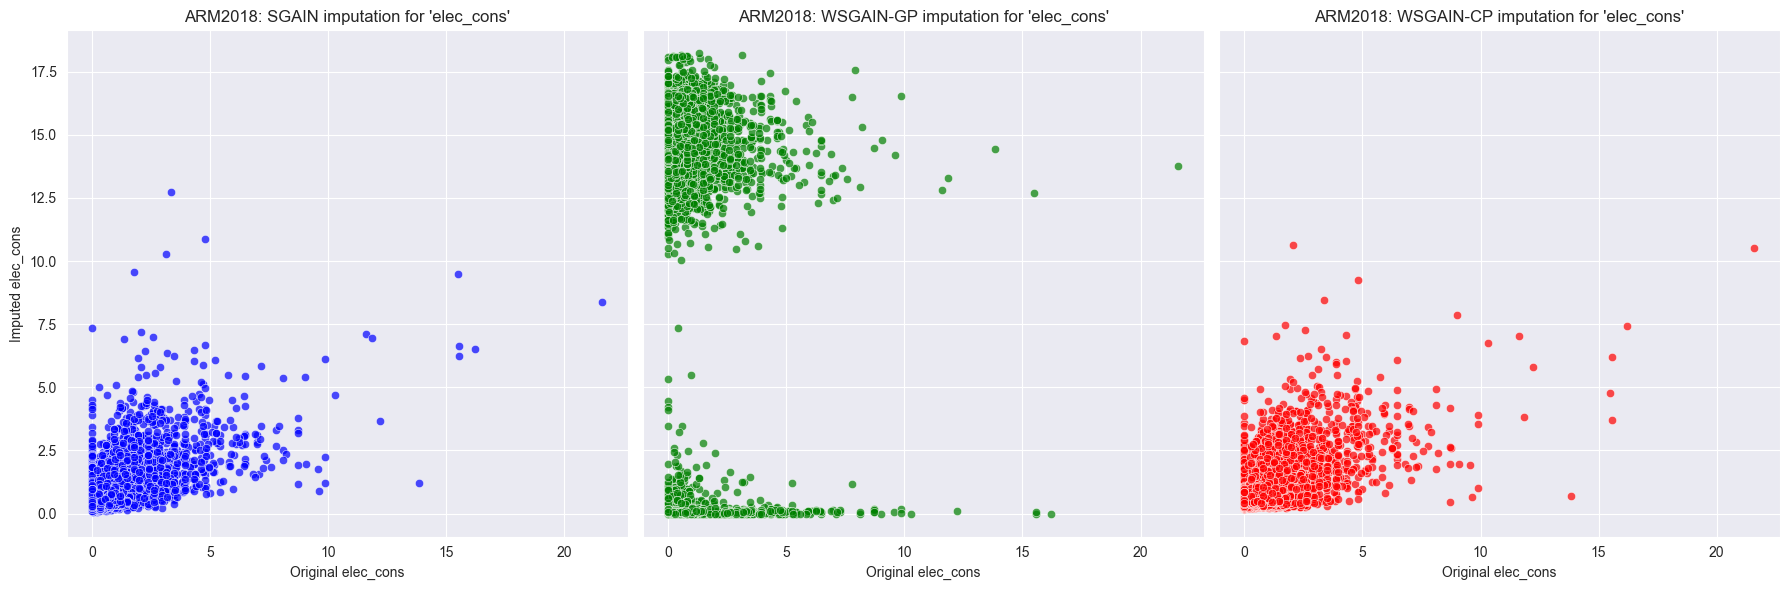

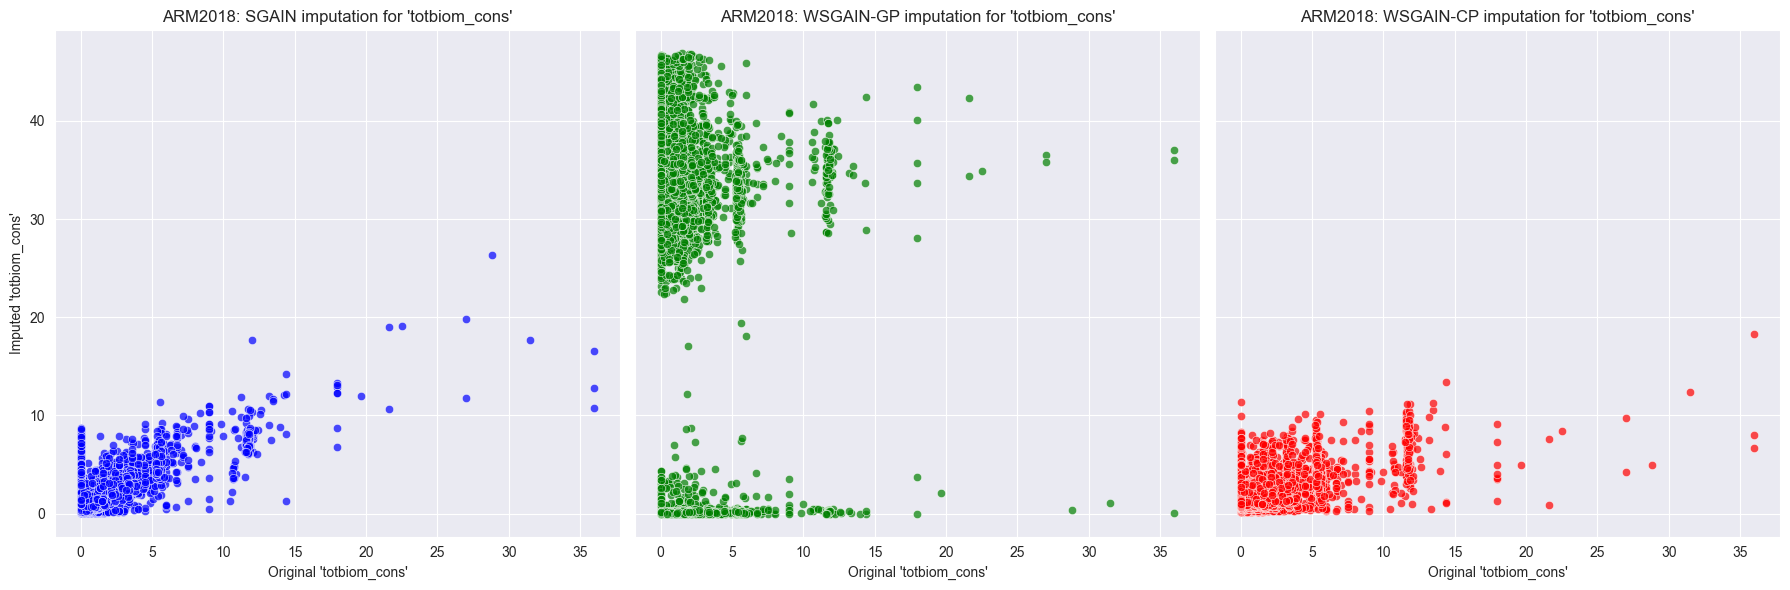

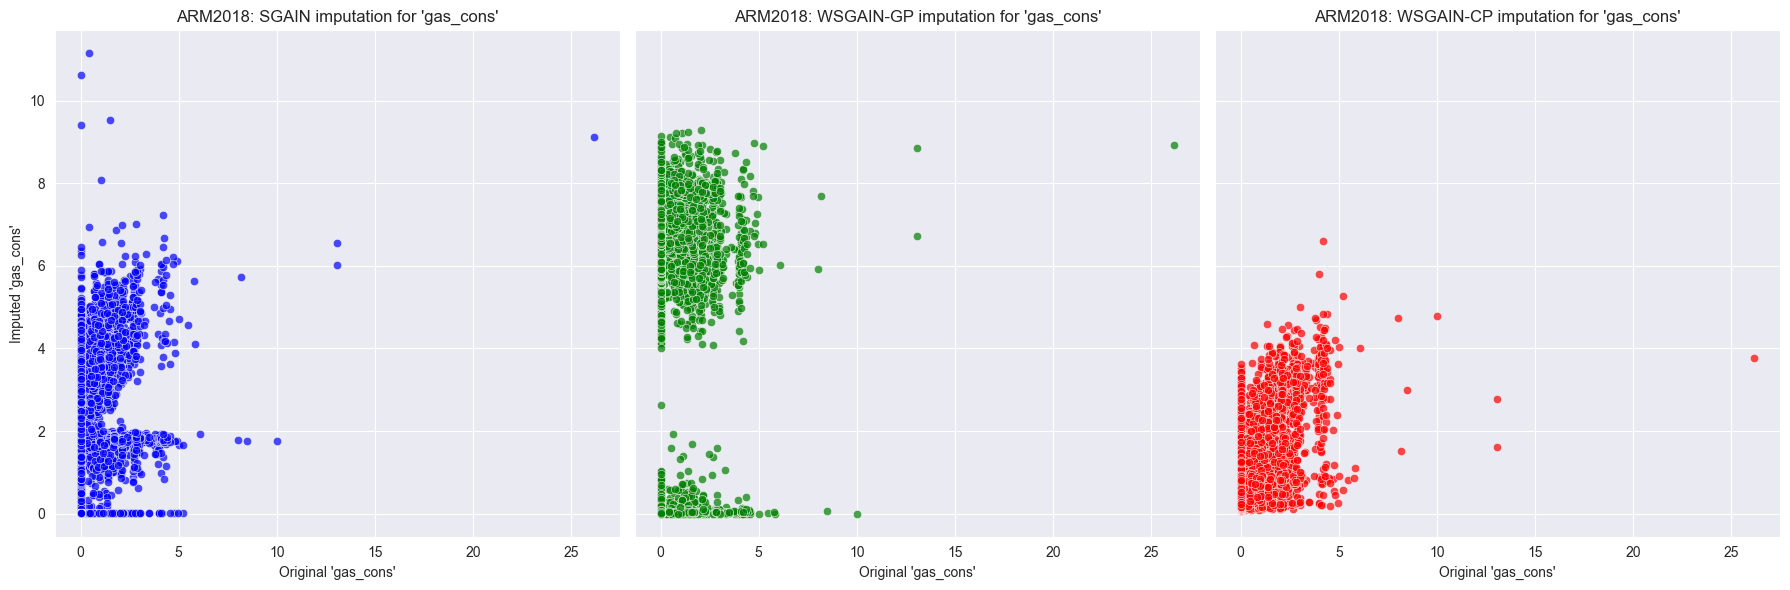

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ARM2018: SGAIN imputation for 'elec_cons'")
axes[0].set_xlabel("Original elec_cons")
axes[0].set_ylabel("Imputed elec_cons")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ARM2018: WSGAIN-GP imputation for 'elec_cons'")
axes[1].set_xlabel("Original elec_cons")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ARM2018: WSGAIN-CP imputation for 'elec_cons'")
axes[2].set_xlabel("Original elec_cons")


plt.tight_layout()
plt.show()

# plot biomass consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['totbiom_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['totbiom_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['totbiom_cons'],
    'SGAIN': imputation_SGAIN['totbiom_cons']

})

na_mask = mask['totbiom_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ARM2018: SGAIN imputation for 'totbiom_cons'")
axes[0].set_xlabel("Original 'totbiom_cons'")
axes[0].set_ylabel("Imputed 'totbiom_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ARM2018: WSGAIN-GP imputation for 'totbiom_cons'")
axes[1].set_xlabel("Original 'totbiom_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ARM2018: WSGAIN-CP imputation for 'totbiom_cons'")
axes[2].set_xlabel("Original 'totbiom_cons'")


plt.tight_layout()
plt.show()

# plot gas consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['gas_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['gas_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['gas_cons'],
    'SGAIN': imputation_SGAIN['gas_cons']

})

na_mask = mask['gas_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ARM2018: SGAIN imputation for 'gas_cons'")
axes[0].set_xlabel("Original 'gas_cons'")
axes[0].set_ylabel("Imputed 'gas_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ARM2018: WSGAIN-GP imputation for 'gas_cons'")
axes[1].set_xlabel("Original 'gas_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ARM2018: WSGAIN-CP imputation for 'gas_cons'")
axes[2].set_xlabel("Original 'gas_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

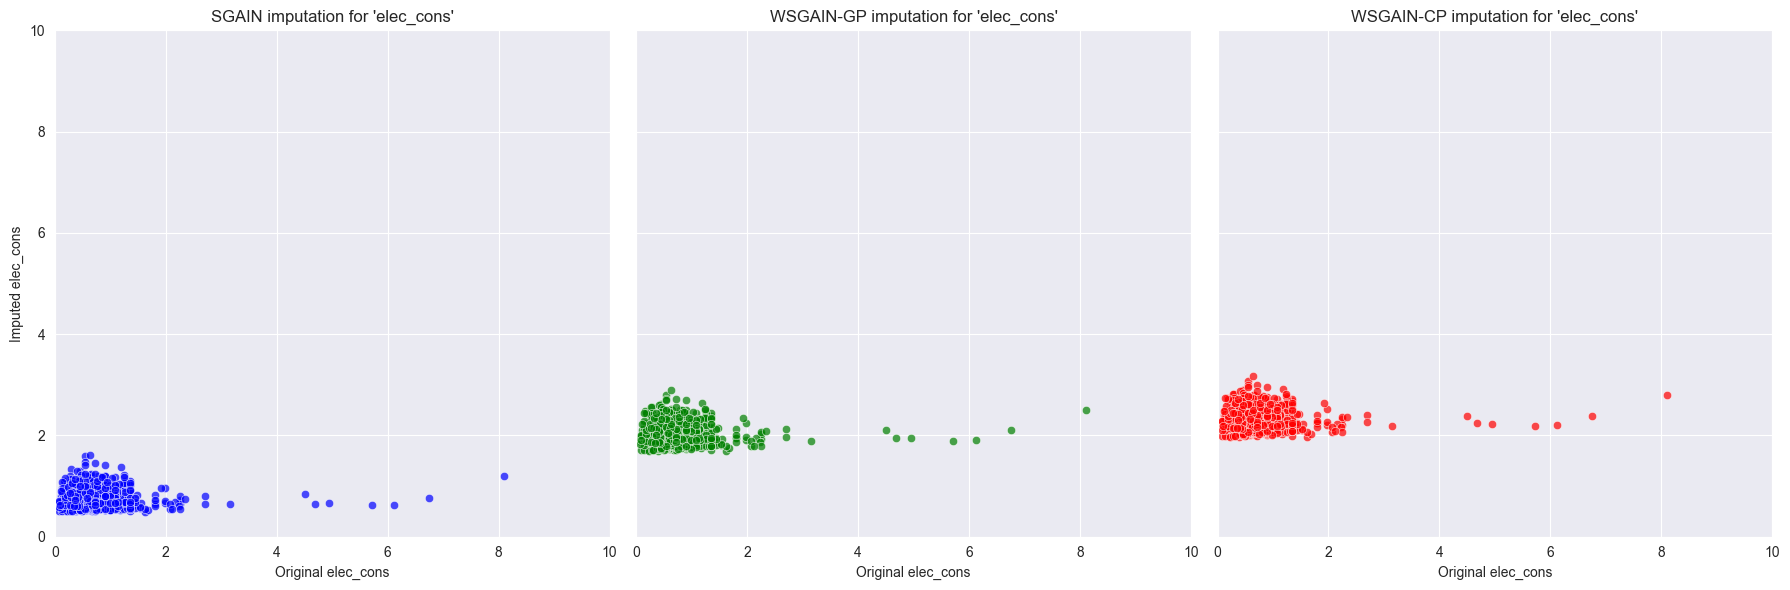

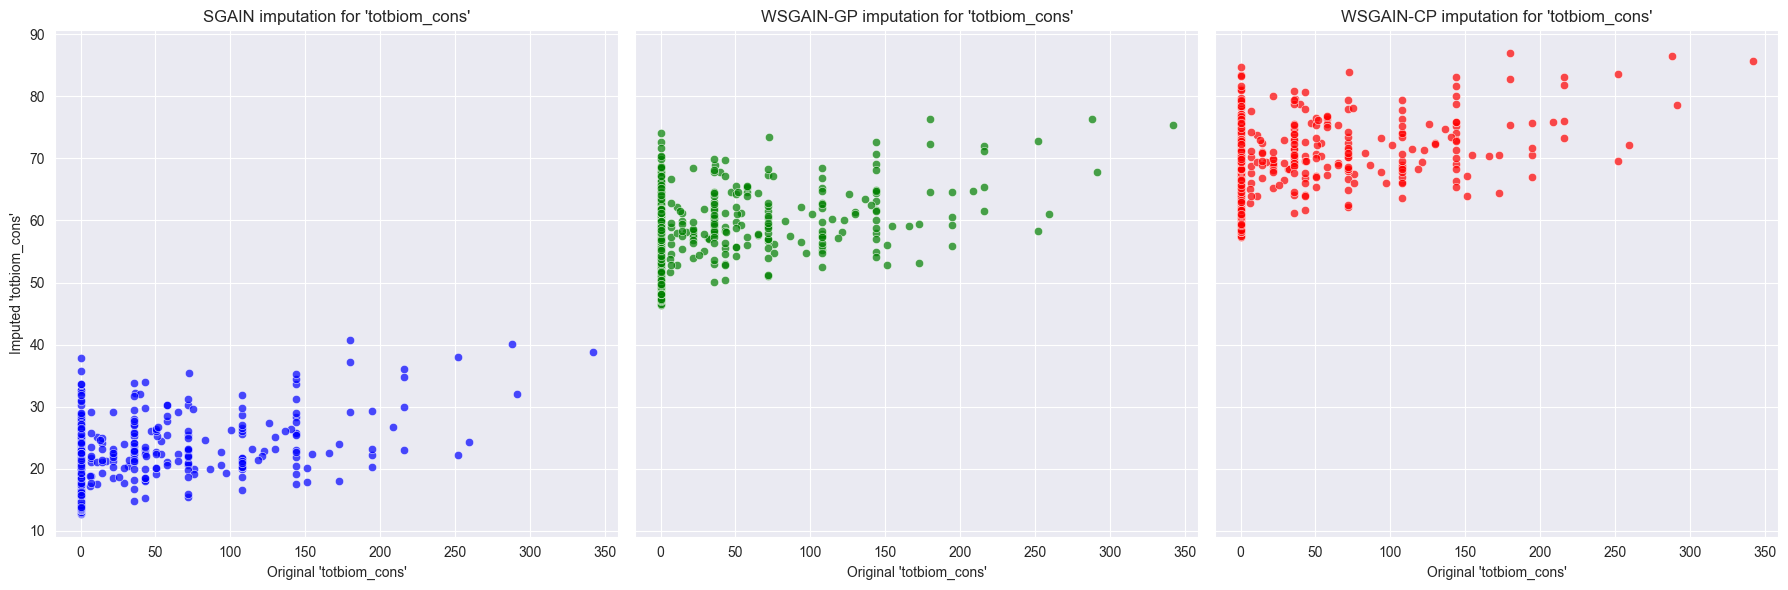

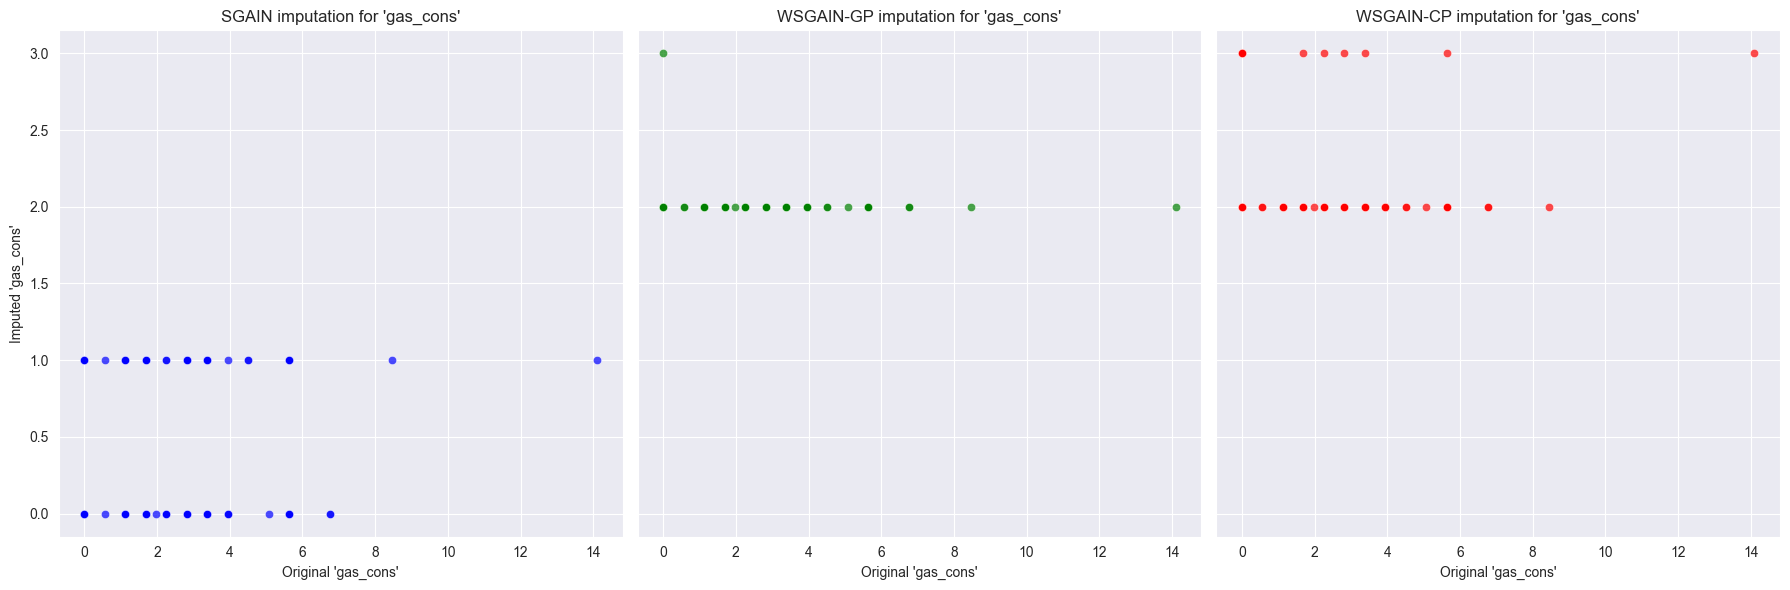

In [13]:
# load in new imputation ------------------------------------------------------------------
imputation_SGAIN = pd.read_csv("datasets/imputations/ARM2018_subset4_evalimputation_run2_SGAIN_00001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/ARM2018_subset4_evalimputation_run2_WSGAIN-GP_00001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/ARM2018_subset4_evalimputation_run2_WSGAIN-CP_00001.csv")

mask = pd.read_csv("datasets/ARM2018_subset4_eval.csv")
original = pd.read_csv("datasets/ARM2018_subset4_noNA.csv")

# plot electricity consumption ----------------------------------------------------------

combined_df = pd.DataFrame({
    'original': original['elec_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['elec_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['elec_cons'],
    'SGAIN': imputation_SGAIN['elec_cons']

})

na_mask = mask['elec_cons'].isna()
filtered_combined_df = combined_df[na_mask]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'elec_cons'")
axes[0].set_xlabel("Original elec_cons")
axes[0].set_ylabel("Imputed elec_cons")
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'elec_cons'")
axes[1].set_xlabel("Original elec_cons")
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'elec_cons'")
axes[2].set_xlabel("Original elec_cons")
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot biomass consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['totbiom_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['totbiom_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['totbiom_cons'],
    'SGAIN': imputation_SGAIN['totbiom_cons']

})

na_mask = mask['totbiom_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'totbiom_cons'")
axes[0].set_xlabel("Original 'totbiom_cons'")
axes[0].set_ylabel("Imputed 'totbiom_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'totbiom_cons'")
axes[1].set_xlabel("Original 'totbiom_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'totbiom_cons'")
axes[2].set_xlabel("Original 'totbiom_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot gas consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['gas_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['gas_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['gas_cons'],
    'SGAIN': imputation_SGAIN['gas_cons']

})

na_mask = mask['gas_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'gas_cons'")
axes[0].set_xlabel("Original 'gas_cons'")
axes[0].set_ylabel("Imputed 'gas_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'gas_cons'")
axes[1].set_xlabel("Original 'gas_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'gas_cons'")
axes[2].set_xlabel("Original 'gas_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Imputation with following parameters:

    miss rate:    0
    batch size:   128
    alpha:        100
    clip values:  (-0.01, 0.01)
    optimizer:    Adam
    learn. rate:  0.0001
    beta 1:       0.9
    beta 2:       0.999
    epsilon:      1e-08
    iterations: 10000
    critic:     5
    runs:       3
    verbose:      False

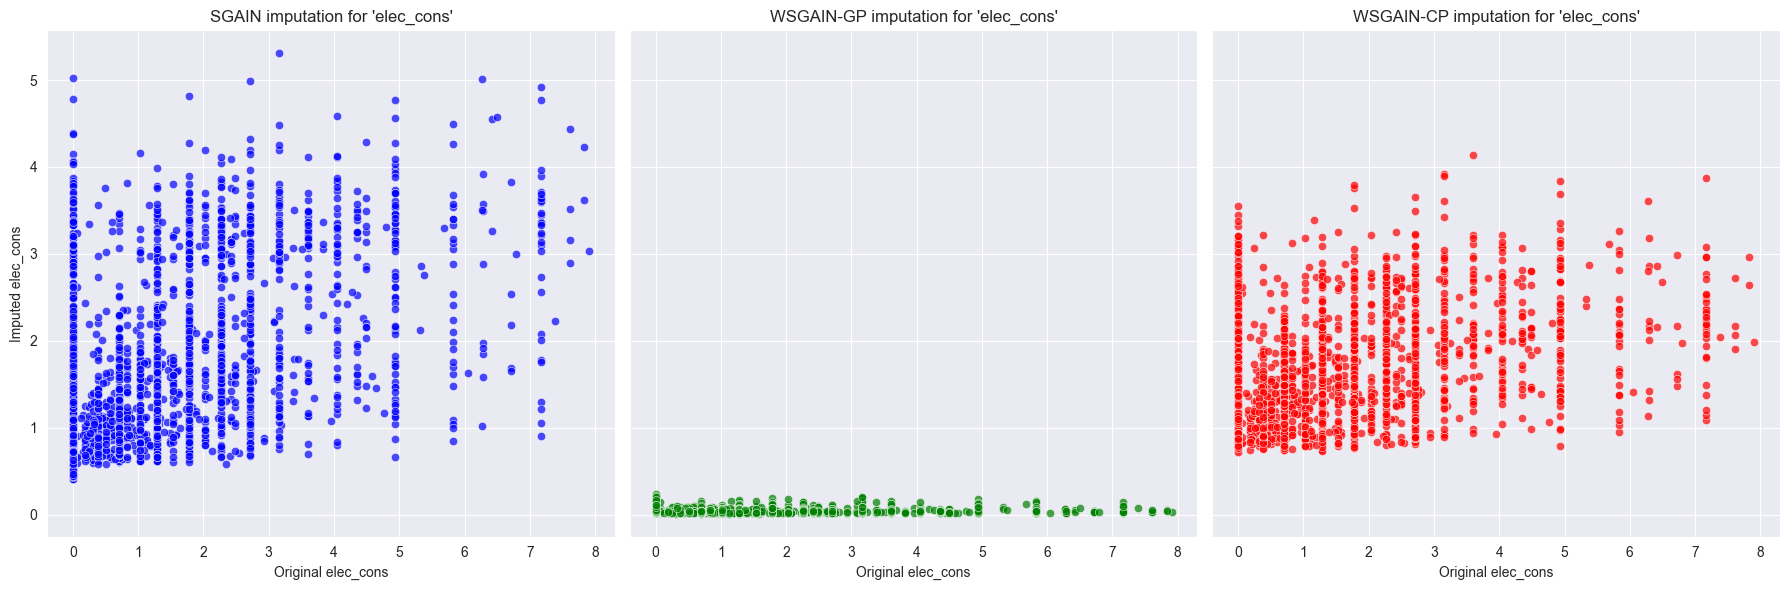

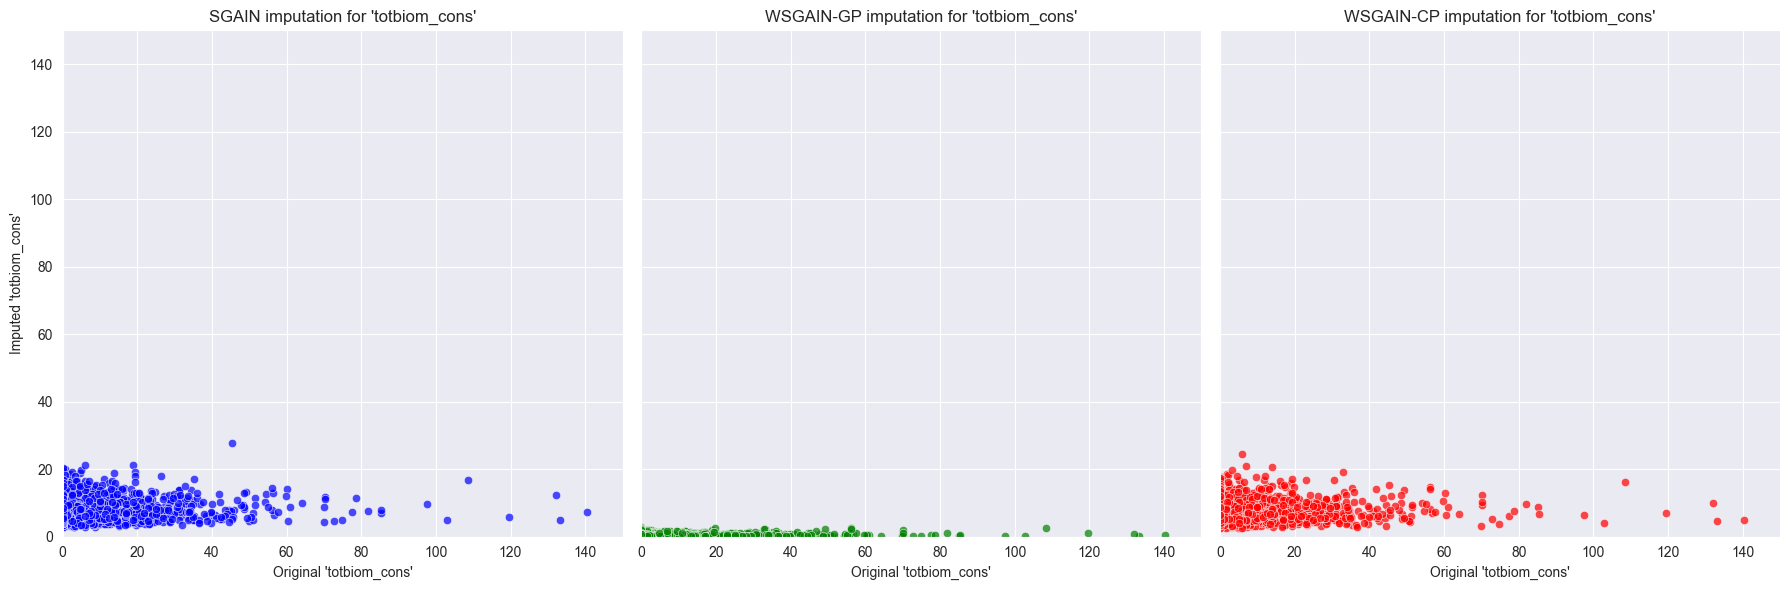

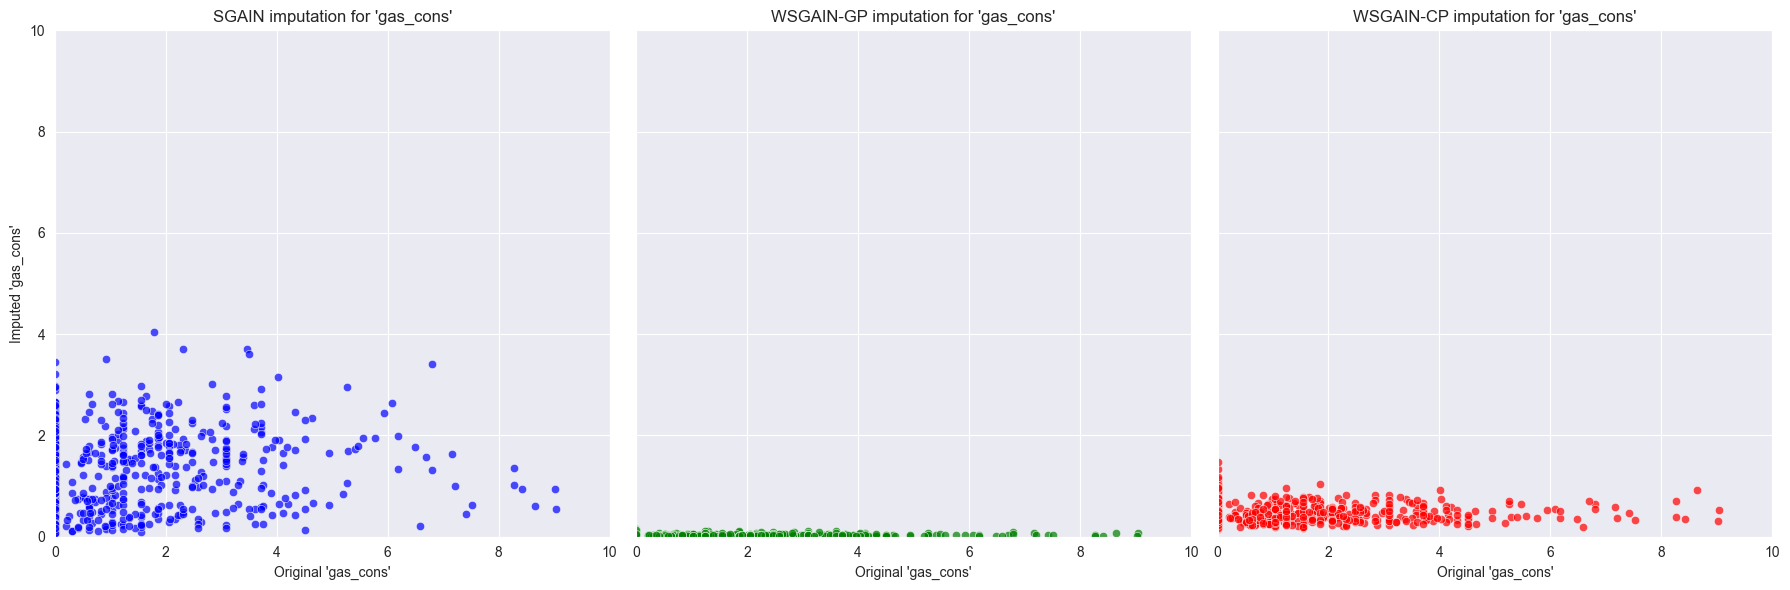

In [14]:
# load in new imputation ------------------------------------------------------------------
imputation_SGAIN = pd.read_csv("datasets/imputations/GHA2017_subset4_evalimputation_run2_SGAIN_0001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/GHA2017_subset4_evalimputation_run2_WSGAIN-GP_0001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/GHA2017_subset4_evalimputation_run2_WSGAIN-CP_0001.csv")

mask = pd.read_csv("datasets/GHA2017_subset4_eval.csv")
original = pd.read_csv("datasets/GHA2017_subset4_noNA.csv")

# plot electricity consumption ----------------------------------------------------------

combined_df = pd.DataFrame({
    'original': original['elec_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['elec_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['elec_cons'],
    'SGAIN': imputation_SGAIN['elec_cons']

})

na_mask = mask['elec_cons'].isna()
filtered_combined_df = combined_df[na_mask]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'elec_cons'")
axes[0].set_xlabel("Original elec_cons")
axes[0].set_ylabel("Imputed elec_cons")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'elec_cons'")
axes[1].set_xlabel("Original elec_cons")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'elec_cons'")
axes[2].set_xlabel("Original elec_cons")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot biomass consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['totbiom_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['totbiom_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['totbiom_cons'],
    'SGAIN': imputation_SGAIN['totbiom_cons']

})

na_mask = mask['totbiom_cons'].isna()
filtered_combined_df = combined_df[na_mask]


'''fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'totbiom_cons'")
axes[0].set_xlabel("Original 'totbiom_cons'")
axes[0].set_ylabel("Imputed 'totbiom_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'totbiom_cons'")
axes[1].set_xlabel("Original 'totbiom_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'totbiom_cons'")
axes[2].set_xlabel("Original 'totbiom_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()'''

# second try for biomass consumption ---------------------------------------------------------
'''
# Calculate the range for the axes
min_value = filtered_combined_df[['original', 'SGAIN', 'WSGAIN-GP', 'WSGAIN-CP']].min().min()
max_value = filtered_combined_df[['original', 'SGAIN', 'WSGAIN-GP', 'WSGAIN-CP']].max().max()

'''
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'totbiom_cons'")
axes[0].set_xlabel("Original 'totbiom_cons'")
axes[0].set_ylabel("Imputed 'totbiom_cons'")
axes[0].set_xlim(0, 150)
axes[0].set_ylim(0, 150)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'totbiom_cons'")
axes[1].set_xlabel("Original 'totbiom_cons'")
axes[1].set_xlim(0, 150)
axes[1].set_ylim(0, 150)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'totbiom_cons'")
axes[2].set_xlabel("Original 'totbiom_cons'")
axes[1].set_xlim(0, 150)
axes[1].set_ylim(0, 150)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
# plot gas consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['gas_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['gas_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['gas_cons'],
    'SGAIN': imputation_SGAIN['gas_cons']

})

na_mask = mask['gas_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'gas_cons'")
axes[0].set_xlabel("Original 'gas_cons'")
axes[0].set_ylabel("Imputed 'gas_cons'")
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'gas_cons'")
axes[1].set_xlabel("Original 'gas_cons'")
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'gas_cons'")
axes[2].set_xlabel("Original 'gas_cons'")
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

learn rate

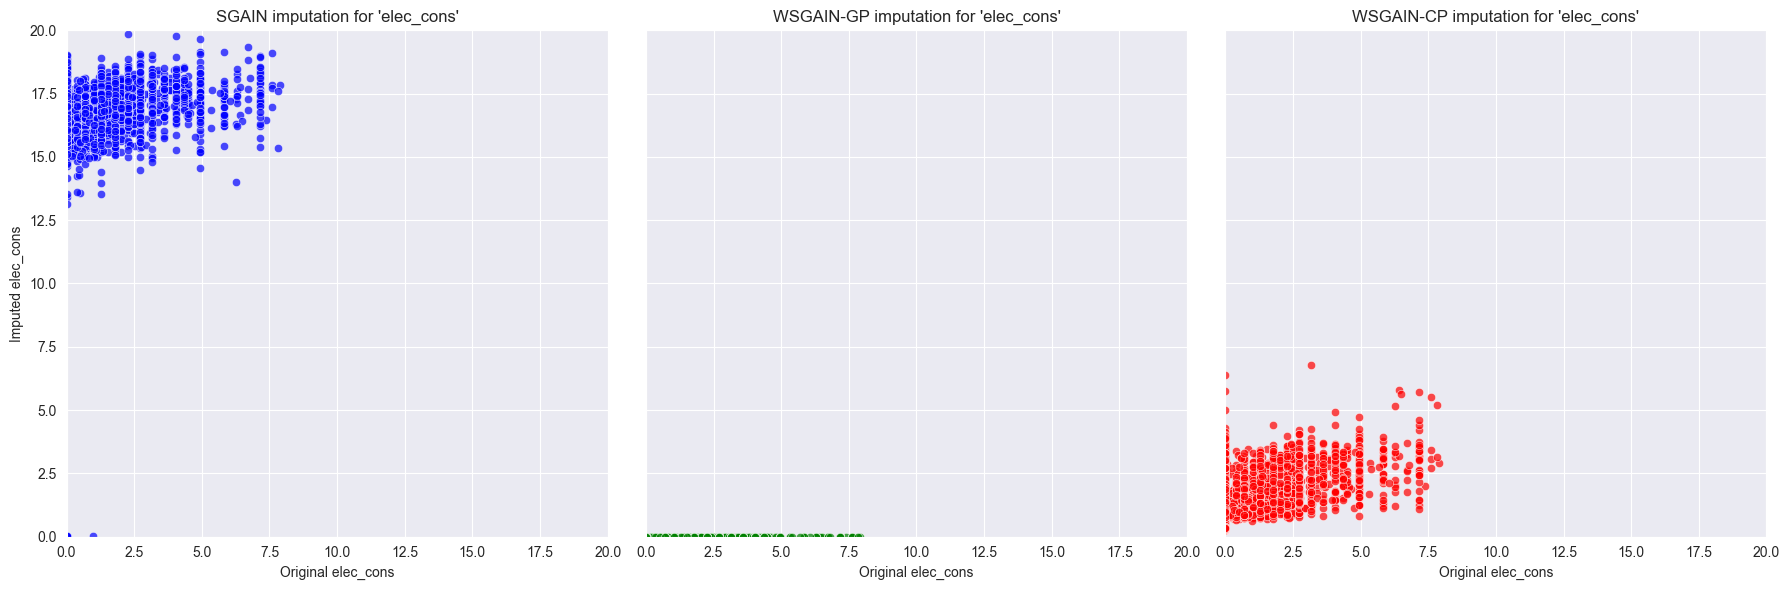

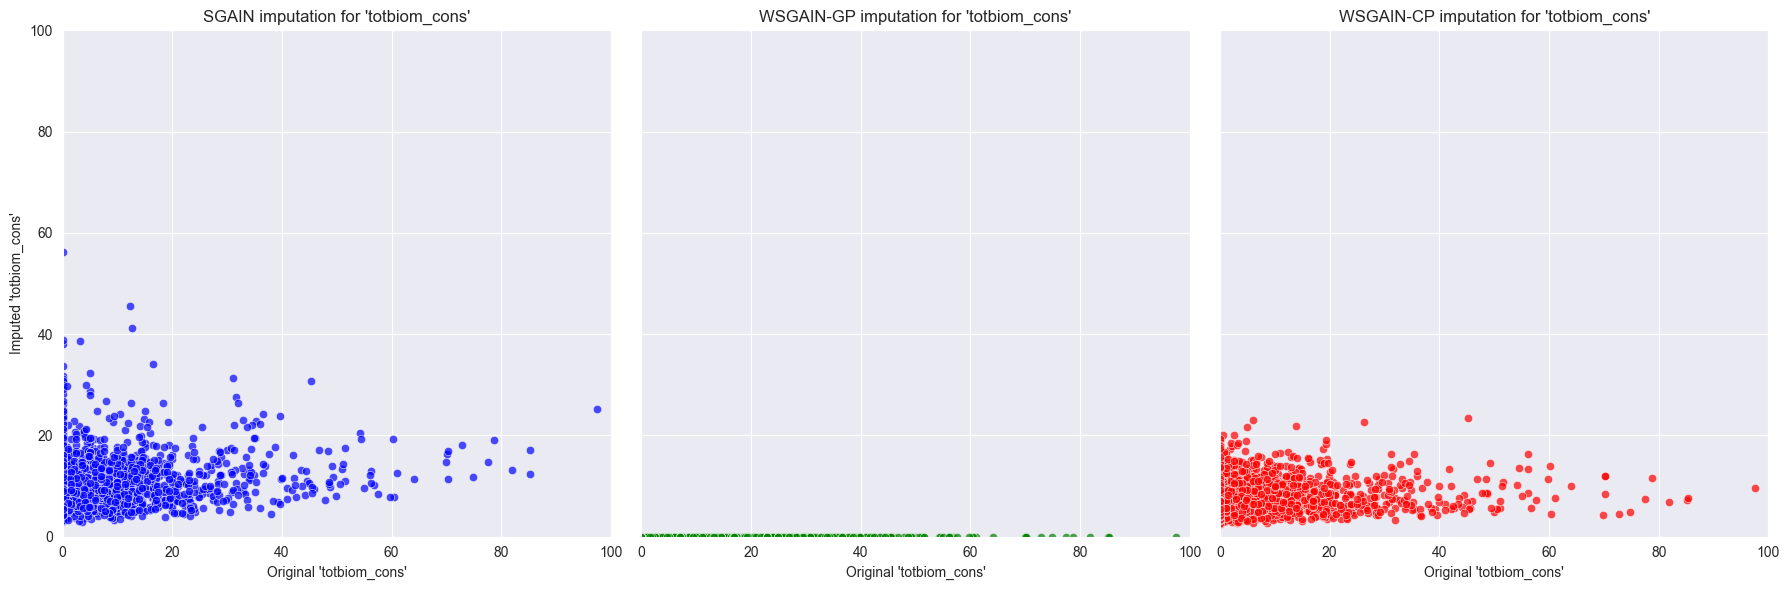

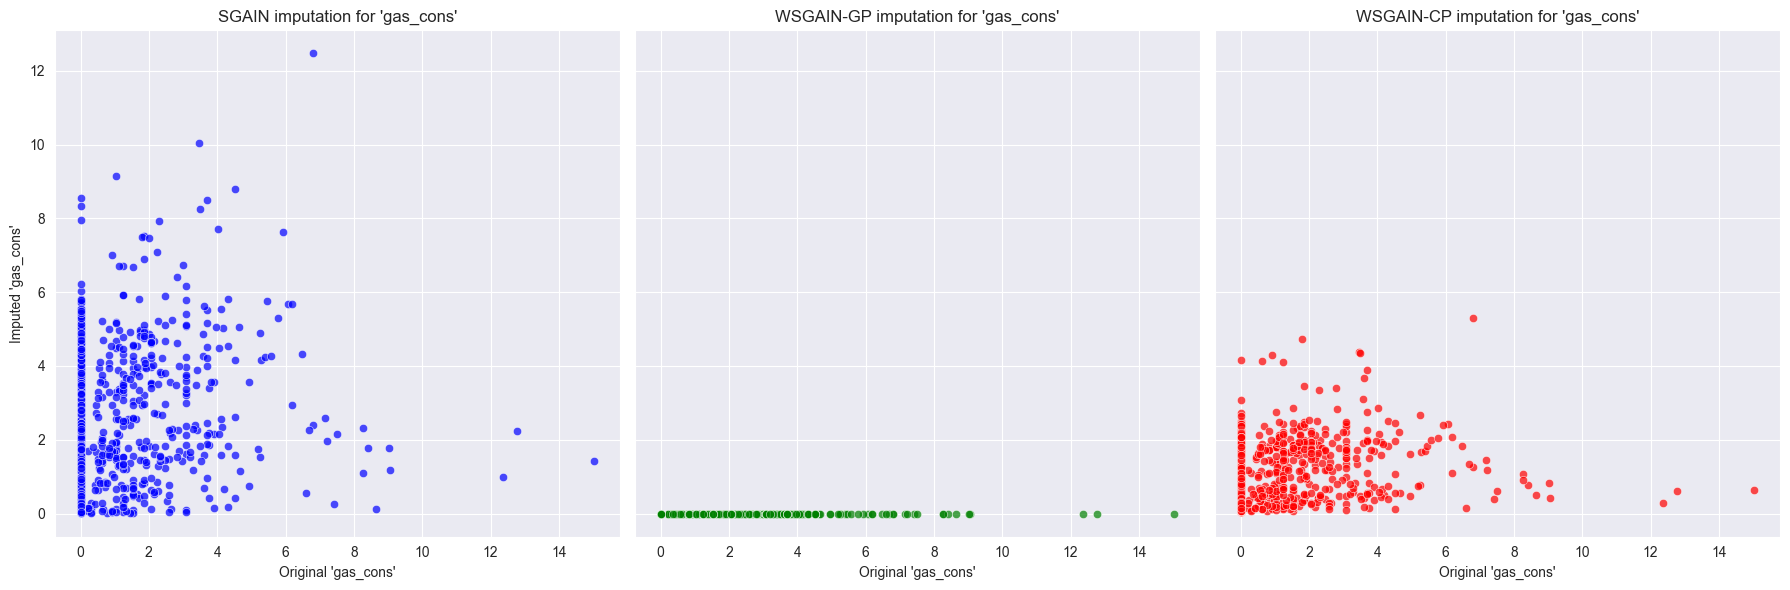

In [15]:
# load in new imputation ------------------------------------------------------------------
imputation_SGAIN = pd.read_csv("datasets/imputations/GHA2017_subset4_evalimputation_run2_SGAIN_001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/GHA2017_subset4_evalimputation_run2_WSGAIN-GP_001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/GHA2017_subset4_evalimputation_run2_WSGAIN-CP_001.csv")

mask = pd.read_csv("datasets/GHA2017_subset4_eval.csv")
original = pd.read_csv("datasets/GHA2017_subset4_noNA.csv")

# plot electricity consumption ----------------------------------------------------------

combined_df = pd.DataFrame({
    'original': original['elec_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['elec_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['elec_cons'],
    'SGAIN': imputation_SGAIN['elec_cons']

})

na_mask = mask['elec_cons'].isna()
filtered_combined_df = combined_df[na_mask]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'elec_cons'")
axes[0].set_xlabel("Original elec_cons")
axes[0].set_ylabel("Imputed elec_cons")
axes[1].set_xlim(0, 20)
axes[1].set_ylim(0, 20)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'elec_cons'")
axes[1].set_xlabel("Original elec_cons")
axes[1].set_xlim(0, 20)
axes[1].set_ylim(0, 20)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'elec_cons'")
axes[2].set_xlabel("Original elec_cons")
axes[1].set_xlim(0, 20)
axes[1].set_ylim(0, 20)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot biomass consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['totbiom_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['totbiom_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['totbiom_cons'],
    'SGAIN': imputation_SGAIN['totbiom_cons']

})

na_mask = mask['totbiom_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'totbiom_cons'")
axes[0].set_xlabel("Original 'totbiom_cons'")
axes[0].set_ylabel("Imputed 'totbiom_cons'")
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)


# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'totbiom_cons'")
axes[1].set_xlabel("Original 'totbiom_cons'")
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'totbiom_cons'")
axes[2].set_xlabel("Original 'totbiom_cons'")
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot gas consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['gas_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['gas_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['gas_cons'],
    'SGAIN': imputation_SGAIN['gas_cons']

})

na_mask = mask['gas_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("SGAIN imputation for 'gas_cons'")
axes[0].set_xlabel("Original 'gas_cons'")
axes[0].set_ylabel("Imputed 'gas_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("WSGAIN-GP imputation for 'gas_cons'")
axes[1].set_xlabel("Original 'gas_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("WSGAIN-CP imputation for 'gas_cons'")
axes[2].set_xlabel("Original 'gas_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

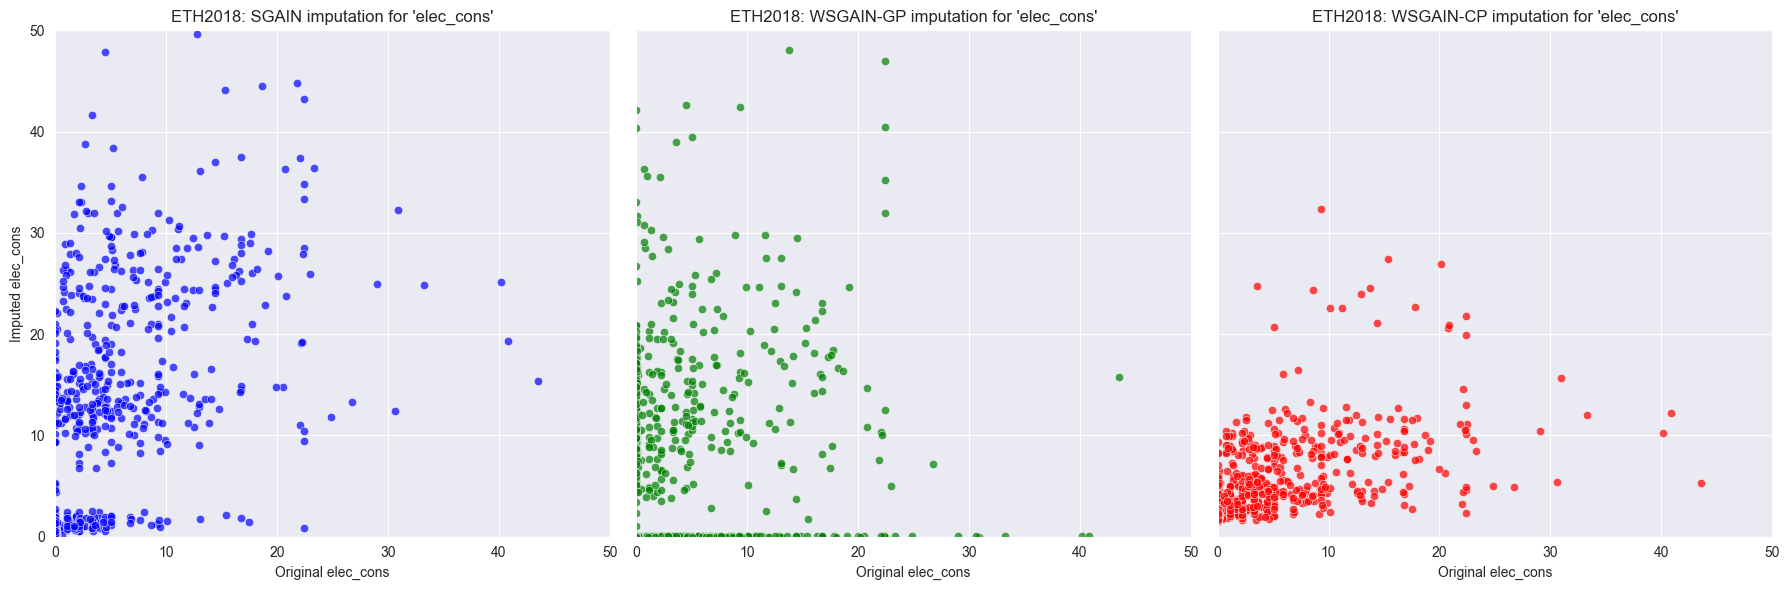

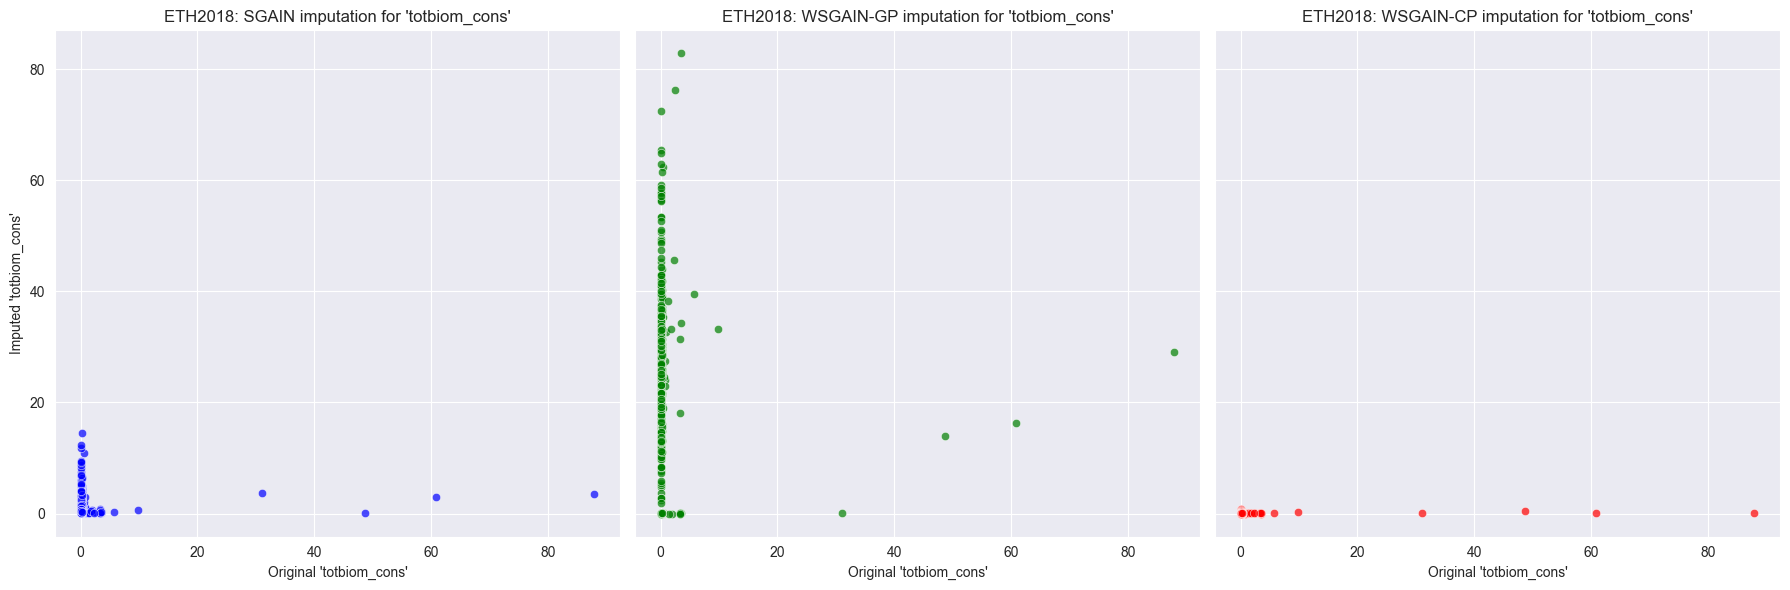

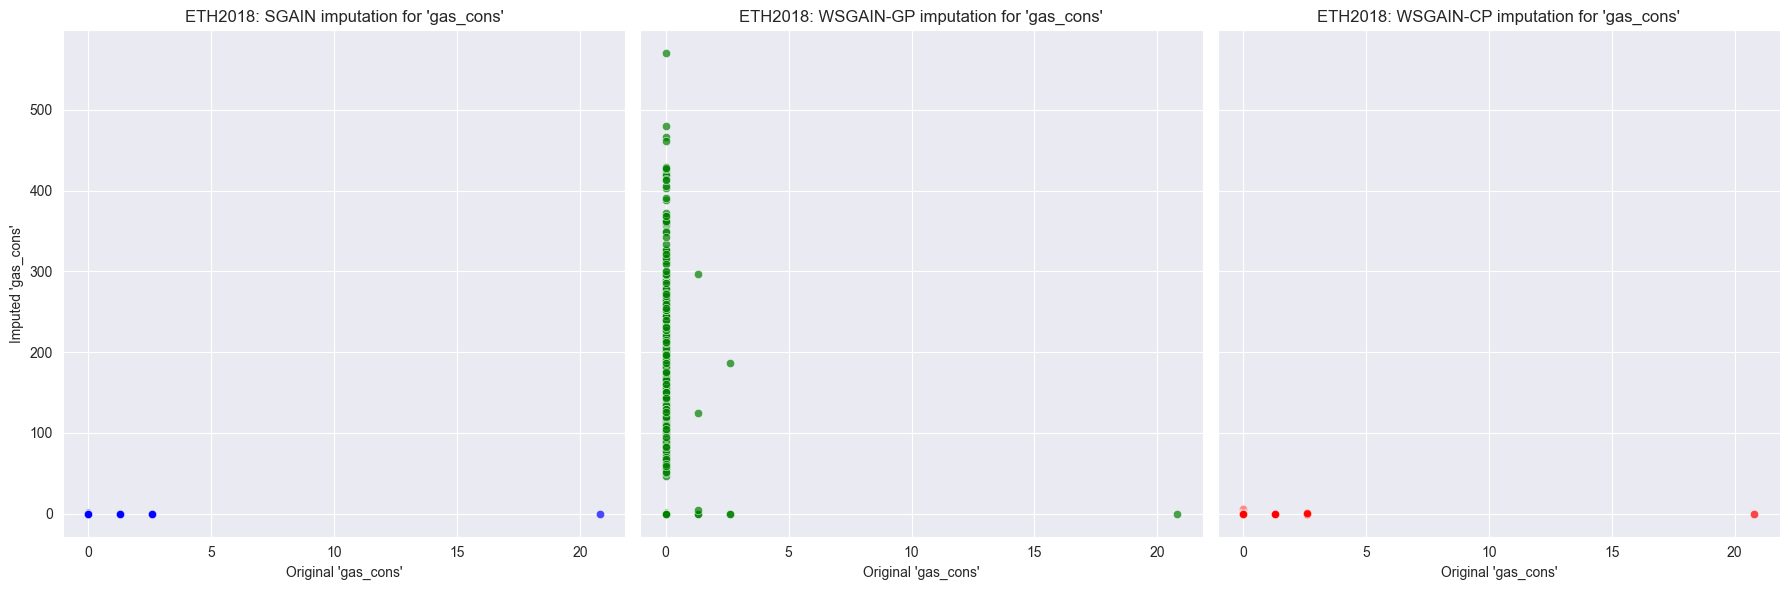

In [16]:
imputation_SGAIN = pd.read_csv("datasets/imputations/ETH2018_subset4_evalimputation_run2_SGAIN_001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/ETH2018_subset4_evalimputation_run2_WSGAIN-GP_001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/ETH2018_subset4_evalimputation_run2_WSGAIN-CP_001.csv")

mask = pd.read_csv("datasets/ETH2018_subset4_eval.csv")
original = pd.read_csv("datasets/ETH2018_subset4_noNA.csv")

# plot electricity consumption
combined_df = pd.DataFrame({
    'original': original['elec_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['elec_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['elec_cons'],
    'SGAIN': imputation_SGAIN['elec_cons'],
    'SGAIN residuals': original['elec_cons'] - imputation_SGAIN['elec_cons']

})

na_mask = mask['elec_cons'].isna()
filtered_combined_df = combined_df[na_mask]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ETH2018: SGAIN imputation for 'elec_cons'")
axes[0].set_xlabel("Original elec_cons")
axes[0].set_ylabel("Imputed elec_cons")
axes[1].set_xlim(0, 50)
axes[1].set_ylim(0, 50)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ETH2018: WSGAIN-GP imputation for 'elec_cons'")
axes[1].set_xlabel("Original elec_cons")
axes[1].set_xlim(0, 50)
axes[1].set_ylim(0, 50)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ETH2018: WSGAIN-CP imputation for 'elec_cons'")
axes[2].set_xlabel("Original elec_cons")
axes[1].set_xlim(0, 50)
axes[1].set_ylim(0, 50)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot biomass consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['totbiom_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['totbiom_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['totbiom_cons'],
    'SGAIN': imputation_SGAIN['totbiom_cons']

})

na_mask = mask['totbiom_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ETH2018: SGAIN imputation for 'totbiom_cons'")
axes[0].set_xlabel("Original 'totbiom_cons'")
axes[0].set_ylabel("Imputed 'totbiom_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ETH2018: WSGAIN-GP imputation for 'totbiom_cons'")
axes[1].set_xlabel("Original 'totbiom_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ETH2018: WSGAIN-CP imputation for 'totbiom_cons'")
axes[2].set_xlabel("Original 'totbiom_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# plot gas consumption --------------------------------------
combined_df = pd.DataFrame({
    'original': original['gas_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['gas_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['gas_cons'],
    'SGAIN': imputation_SGAIN['gas_cons']

})

na_mask = mask['gas_cons'].isna()
filtered_combined_df = combined_df[na_mask]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ETH2018: SGAIN imputation for 'gas_cons'")
axes[0].set_xlabel("Original 'gas_cons'")
axes[0].set_ylabel("Imputed 'gas_cons'")

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ETH2018: WSGAIN-GP imputation for 'gas_cons'")
axes[1].set_xlabel("Original 'gas_cons'")

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ETH2018: WSGAIN-CP imputation for 'gas_cons'")
axes[2].set_xlabel("Original 'gas_cons'")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

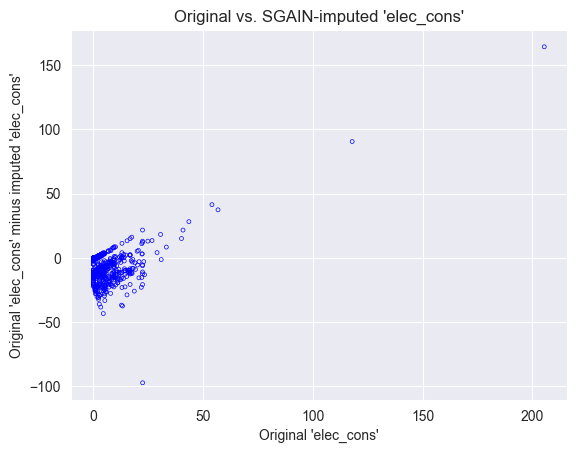

In [17]:
combined_df = pd.DataFrame({
    'original': original['elec_cons'],
    'WSGAIN-GP': imputation_WSGAIN_GP['elec_cons'],
    'WSGAIN-CP': imputation_WSGAIN_CP['elec_cons'],
    'SGAIN': imputation_SGAIN['elec_cons'],
    'SGAIN residuals': original['elec_cons'] - imputation_SGAIN['elec_cons']

})

na_mask = mask['elec_cons'].isna()
filtered_combined_df = combined_df[na_mask]
sns.scatterplot(
    data=filtered_combined_df,
    x='original',
    y='SGAIN residuals',
    s=8,  # Small size
    edgecolor='blue',  # Outline color
    facecolor='none',  # Hollow inside
    linewidth=0.5  # Thinner outlines for better visibility
)
plt.xlabel("Original 'elec_cons'")
plt.ylabel("Original 'elec_cons' minus imputed 'elec_cons'")

plt.title("Original vs. SGAIN-imputed 'elec_cons'")

#djust values as needed
plt.grid(True)
plt.show()

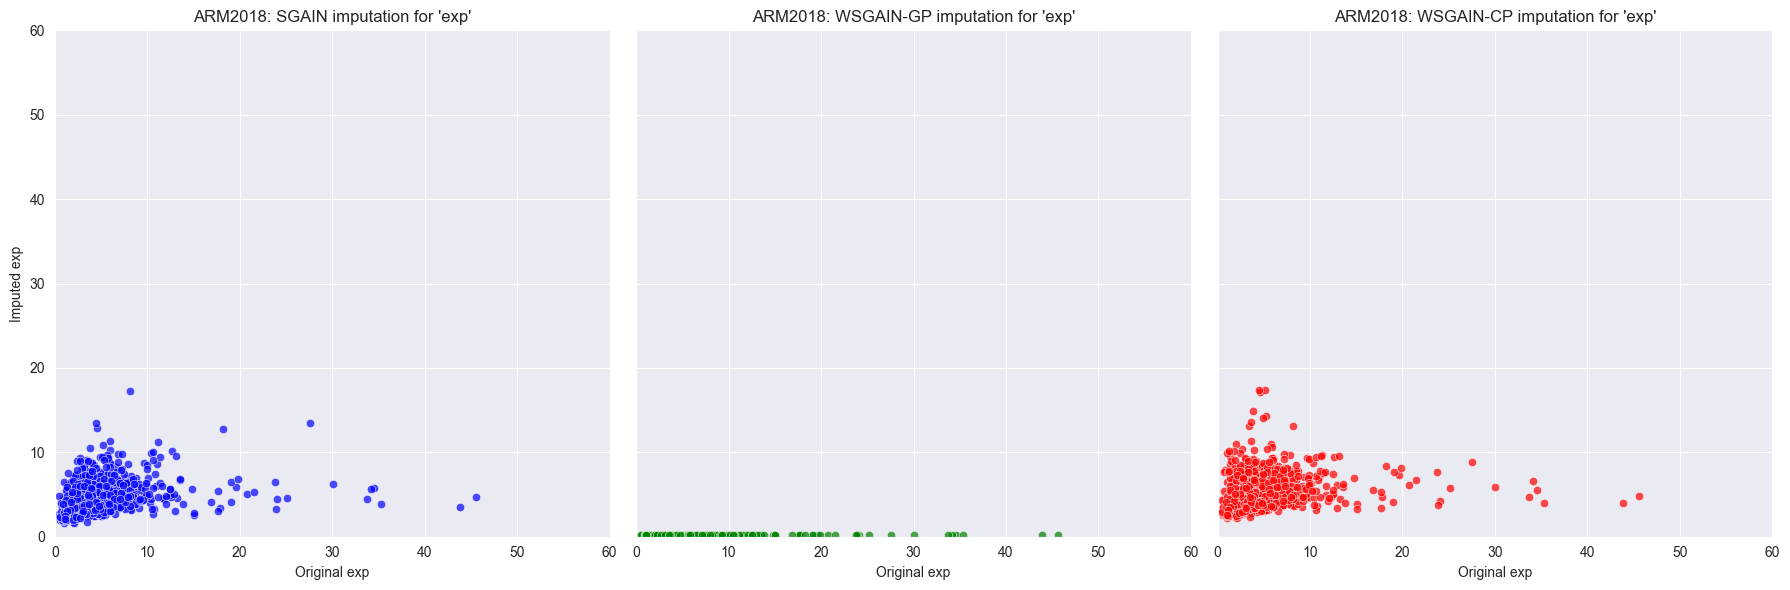

In [18]:
imputation_SGAIN = pd.read_csv("datasets/imputations/ARM2018_subset1_evalimputation_run2_SGAIN_001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/ARM2018_subset1_evalimputation_run2_WSGAIN-GP_001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/ARM2018_subset1_evalimputation_run2_WSGAIN-CP_001.csv")

mask = pd.read_csv("datasets/ARM2018_subset1_eval.csv")
original = pd.read_csv("datasets/ARM2018_subset1_noNA.csv")

# plot electricity consumption
combined_df = pd.DataFrame({
    'original': original['exp'],
    'WSGAIN-GP': imputation_WSGAIN_GP['exp'],
    'WSGAIN-CP': imputation_WSGAIN_CP['exp'],
    'SGAIN': imputation_SGAIN['exp'],
    'WSGAIN-GP residuals': (original['exp']-imputation_WSGAIN_GP['exp']),
    'WSGAIN-CP residuals': (original['exp']-imputation_WSGAIN_CP['exp']),
    'SGAIN residuals': (original['exp']-imputation_SGAIN['exp'])

})

na_mask = mask['exp'].isna()
filtered_combined_df = combined_df[na_mask]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ARM2018: SGAIN imputation for 'exp'")
axes[0].set_xlabel("Original exp")
axes[0].set_ylabel("Imputed exp")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ARM2018: WSGAIN-GP imputation for 'exp'")
axes[1].set_xlabel("Original exp")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ARM2018: WSGAIN-CP imputation for 'exp'")
axes[2].set_xlabel("Original exp")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

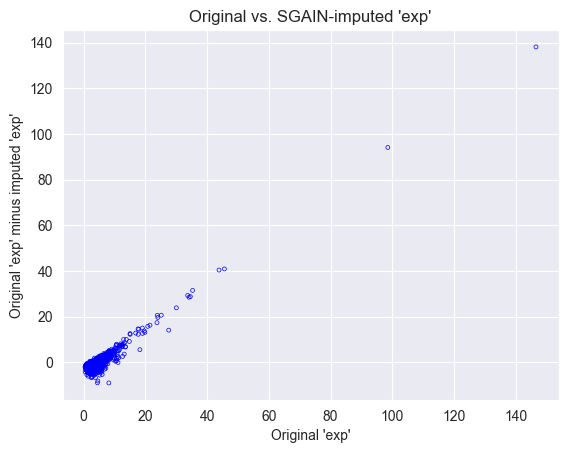

In [19]:
import seaborn as sns

# Scatter plot with hollow dots using Matplotlib settings
sns.scatterplot(
    data=filtered_combined_df,
    x='original',
    y='SGAIN residuals',
    s=8,  # Small size
    edgecolor='blue',  # Outline color
    facecolor='none',  # Hollow inside
    linewidth=0.5  # Thinner outlines for better visibility
)
plt.xlabel("Original 'exp'")
plt.ylabel("Original 'exp' minus imputed 'exp'")

plt.title("Original vs. SGAIN-imputed 'exp'")

#djust values as needed
plt.grid(True)
plt.show()

In [20]:
# deviation greater 5
great_dev = filtered_combined_df["SGAIN residuals"] > 0.5
sum(great_dev)
sum(great_dev)/len(great_dev)

0.2761627906976744

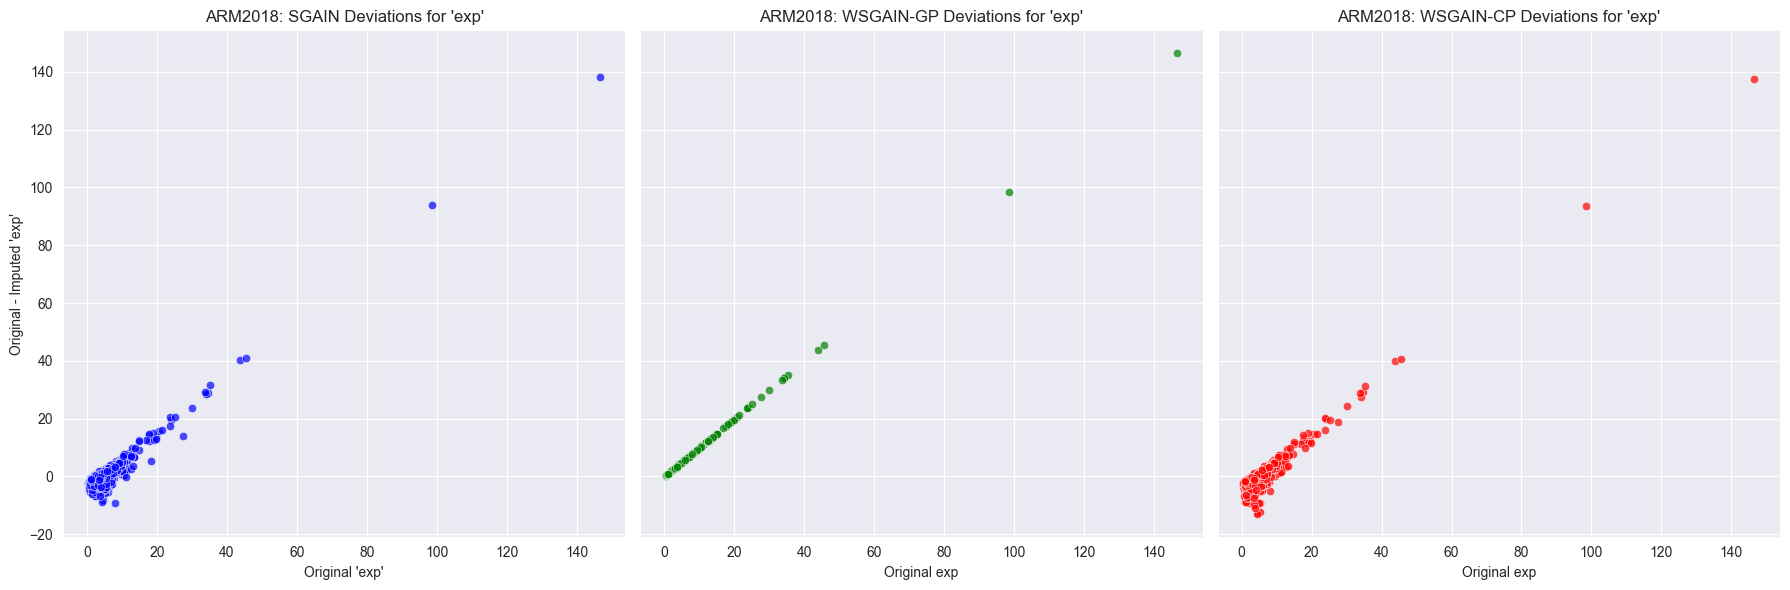

In [21]:
# Create subplots with 1 row and 3 columns
imputation_SGAIN = pd.read_csv("datasets/imputations/ARM2018_subset1_evalimputation_run2_SGAIN_001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/ARM2018_subset1_evalimputation_run2_WSGAIN-GP_001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/ARM2018_subset1_evalimputation_run2_WSGAIN-CP_001.csv")

mask = pd.read_csv("datasets/ARM2018_subset1_eval.csv")
original = pd.read_csv("datasets/ARM2018_subset1_noNA.csv")

# plot electricity consumption
combined_df = pd.DataFrame({
    'original': original['exp'],
    'WSGAIN-GP': imputation_WSGAIN_GP['exp'],
    'WSGAIN-CP': imputation_WSGAIN_CP['exp'],
    'SGAIN': imputation_SGAIN['exp'],
    'WSGAIN-GP residuals': (original['exp']-imputation_WSGAIN_GP['exp']),
    'WSGAIN-CP residuals': (original['exp']-imputation_WSGAIN_CP['exp']),
    'SGAIN residuals': (original['exp']-imputation_SGAIN['exp'])

})

na_mask = mask['exp'].isna()
filtered_combined_df = combined_df[na_mask]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN residuals', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ARM2018: SGAIN Deviations for 'exp'")
axes[0].set_xlabel("Original 'exp'")
axes[0].set_ylabel("Original - Imputed 'exp'")
'''axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)'''

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP residuals', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ARM2018: WSGAIN-GP Deviations for 'exp'")
axes[1].set_xlabel("Original exp")
'''axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)'''

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP residuals', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ARM2018: WSGAIN-CP Deviations for 'exp'")
axes[2].set_xlabel("Original exp")
'''axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)'''
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [27]:
original.head()

,Unnamed: 0,year,country,hhid,hhweight,climatezone,urban,head_age,nrooms,head_literate,hhsize,tv,music,fridge,exp,exp_cap_group
0,0,2018,ARM,1,254.351852,15.0,1,66.0,4.0,1.0,3,1.0,0.0,1.0,2.058754,Top10
1,1,2018,ARM,2,254.351852,15.0,1,57.0,4.0,1.0,8,1.0,0.0,1.0,1.290810,Bot40
2,2,2018,ARM,3,254.351852,15.0,1,70.0,4.0,1.0,4,1.0,0.0,1.0,1.933548,Mid50
3,3,2018,ARM,4,254.351852,15.0,1,58.0,3.0,1.0,9,1.0,0.0,1.0,2.339031,Mid50
4,4,2018,ARM,5,254.351852,15.0,1,56.0,4.0,1.0,4,1.0,0.0,1.0,3.543028,Top10


In [25]:
imputation_SGAIN = pd.read_csv("datasets/imputations/ARM2018_subset1_eval_logimputation_run2_SGAIN_001.csv")
imputation_WSGAIN_GP = pd.read_csv("datasets/imputations/ARM2018_subset1_eval_logimputation_run2_WSGAIN-GP_001.csv")
imputation_WSGAIN_CP = pd.read_csv("datasets/imputations/ARM2018_subset1_eval_logimputation_run2_WSGAIN-CP_001.csv")

mask = pd.read_csv("datasets/ARM2018_subset1_eval.csv")
original = pd.read_csv("datasets/ARM2018_subset1_noNA_log.csv")

# plot electricity consumption
combined_df = pd.DataFrame({
    'original': original['exp'],
    'WSGAIN-GP': imputation_WSGAIN_GP['exp'],
    'WSGAIN-CP': imputation_WSGAIN_CP['exp'],
    'SGAIN': imputation_SGAIN['exp'],
    'WSGAIN-GP residuals': (original['exp']-imputation_WSGAIN_GP['exp']),
    'WSGAIN-CP residuals': (original['exp']-imputation_WSGAIN_CP['exp']),
    'SGAIN residuals': (original['exp']-imputation_SGAIN['exp'])

})

na_mask = mask['exp'].isna()
filtered_combined_df = combined_df[na_mask]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot SGAIN
sns.scatterplot(data=filtered_combined_df, x='original', y='SGAIN', color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("ARM2018: SGAIN imputation for 'exp'")
axes[0].set_xlabel("Original exp")
axes[0].set_ylabel("Imputed exp")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)

# Plot WSGAIN-GP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-GP', color='green', alpha=0.7, ax=axes[1])
axes[1].set_title("ARM2018: WSGAIN-GP imputation for 'exp'")
axes[1].set_xlabel("Original exp")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)

# Plot WSGAIN-CP
sns.scatterplot(data=filtered_combined_df, x='original', y='WSGAIN-CP', color='red', alpha=0.7, ax=axes[2])
axes[2].set_title("ARM2018: WSGAIN-CP imputation for 'exp'")
axes[2].set_xlabel("Original exp")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(0, 60)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

KeyError: 'exp'